## Dataset

The historical dataset of ^SOX and ^VIX prices were obtained using the Yahoo Finance API **`yfinance`** at 1-day interval.

### Installing & Importing Libraries 

In [1]:
# !pip install arch

In [2]:
# !pip3 install yfinance

In [3]:
# !pip install tensorflow

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
from scipy import stats

%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Load Data

In [7]:
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
pd.set_option('display.max_colwidth', None)

In [8]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

In [9]:
# SET SEED FOR REPRODUCIBILITY
seed = 2021

In [10]:
# SET START AND END DATE
start = datetime(2012, 1, 1)
end = datetime(2022, 12, 1)

### **VIX Data**

In [11]:
tckr_VIX = '^VIX'

ticker_VIX = yf.Ticker(tckr_VIX)

df_VIX = ticker_VIX.history(start=start, 
                    end=end, 
                    interval="1d")

In [12]:
#df_VIX.index = pd.to_datetime(df_VIX.index)
df_VIX.index = df_VIX.index.date

In [13]:
df_VIX['VIX2'] = df_VIX['Close']**2

In [14]:
df_VIX['VIX_Returns'] = 100 * df_VIX.Close.pct_change()
df_VIX['VIX2_Returns'] = 100 * df_VIX.VIX2.pct_change()
df_VIX['VIX_Log_Returns'] = np.log(df_VIX.Close/df_VIX.Close.shift(1))
df_VIX['VIX2_Log_Returns'] = np.log(df_VIX.VIX2/df_VIX.VIX2.shift(1))

In [15]:
df_VIX.rename(columns={'Close': 'VIX'}, inplace=True)
df_VIX = df_VIX.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

In [16]:
df_VIX.head()

VIX        VIX2  VIX_Returns  VIX2_Returns  VIX_Log_Returns  \
2012-01-03  22.969999  527.620868          NaN           NaN              NaN   
2012-01-04  22.219999  493.728369    -3.265129     -6.423646        -0.033196   
2012-01-05  21.480000  461.390380    -3.330332     -6.549753        -0.033871   
2012-01-06  20.629999  425.596865    -3.957171     -7.757751        -0.040376   
2012-01-09  21.070000  443.944887     2.132819      4.311127         0.021104   

            VIX2_Log_Returns  
2012-01-03               NaN  
2012-01-04         -0.066392  
2012-01-05         -0.067741  
2012-01-06         -0.080752  
2012-01-09          0.042208

### SOX Data

In [17]:
tckr_SOX = '^SOX'

ticker_SOX = yf.Ticker(tckr_SOX)

df_SOX = ticker_SOX.history(start=start, 
                    end=end, 
                    interval="1d")

In [18]:
# Merge VIX data to SOX dataframe
#df_SOX.index = pd.to_datetime(df_SOX.index)
df_SOX.index = df_SOX.index.date
df_SOX.rename(columns={'Close': 'SOX'}, inplace=True)
df_SOX = df_SOX.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)
df_SOX.head()

SOX
2012-01-03  368.421753
2012-01-04  368.481720
2012-01-05  373.989044
2012-01-06  375.038544
2012-01-09  382.404968

In [19]:
df = pd.merge(df_SOX, df_VIX, left_index=True, right_index=True, how='inner')
df.head()

SOX        VIX        VIX2  VIX_Returns  VIX2_Returns  \
2012-01-03  368.421753  22.969999  527.620868          NaN           NaN   
2012-01-04  368.481720  22.219999  493.728369    -3.265129     -6.423646   
2012-01-05  373.989044  21.480000  461.390380    -3.330332     -6.549753   
2012-01-06  375.038544  20.629999  425.596865    -3.957171     -7.757751   
2012-01-09  382.404968  21.070000  443.944887     2.132819      4.311127   

            VIX_Log_Returns  VIX2_Log_Returns  
2012-01-03              NaN               NaN  
2012-01-04        -0.033196         -0.066392  
2012-01-05        -0.033871         -0.067741  
2012-01-06        -0.040376         -0.080752  
2012-01-09         0.021104          0.042208

### SOX Data Visualization

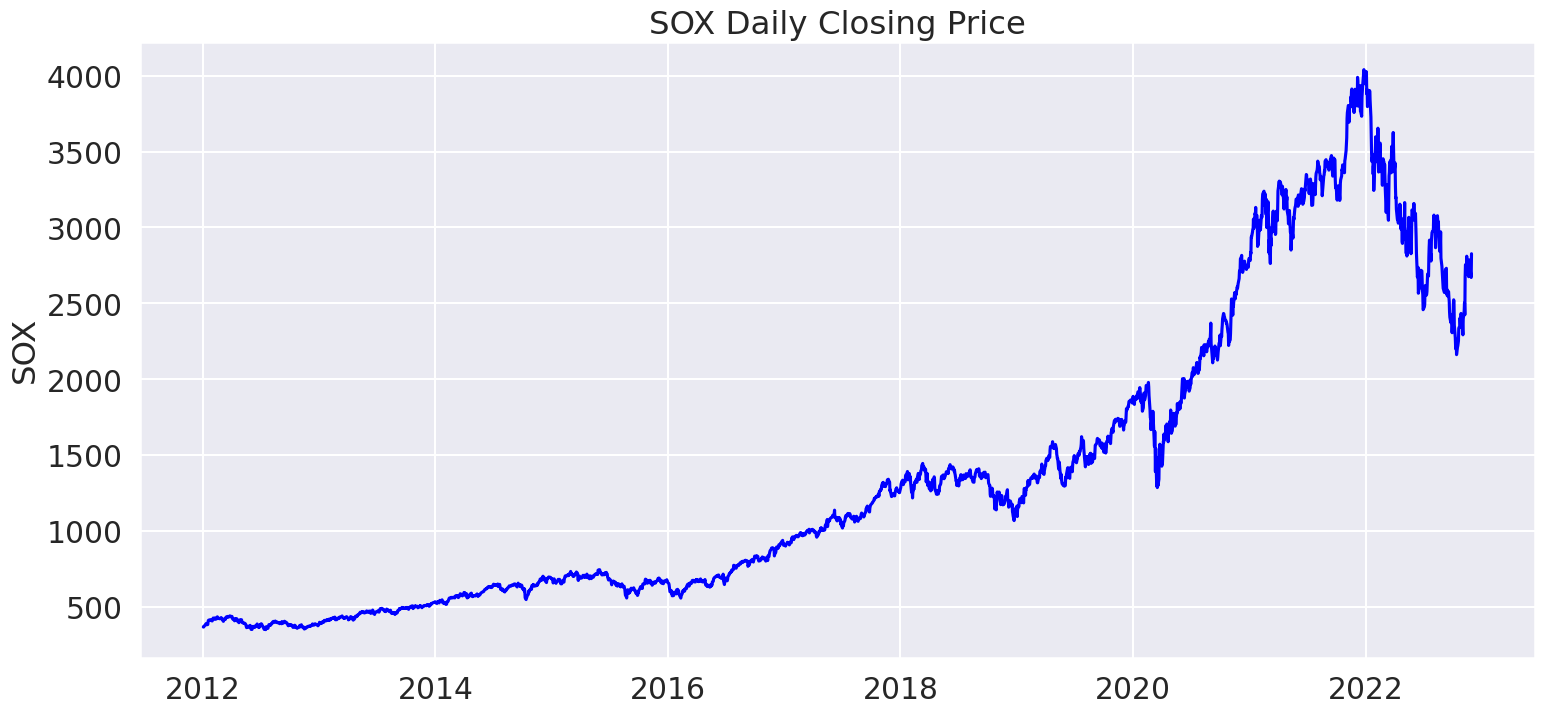

In [20]:
sns.set_context("talk", font_scale=1.3)

# PLOT OUT SOX CLOSING PRICES
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.SOX, color='blue')
    ax.set_title('SOX Daily Closing Price')    

# plt.tight_layout()

In [21]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df.insert(3,'SOX_Returns','')
df['SOX_Returns'] = 100 * df.SOX.pct_change().dropna()

In [22]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df.insert(6,'SOX_Log_Returns','')
df['SOX_Log_Returns'] = np.log(df.SOX/df.SOX.shift(1))

In [23]:
df.head()

SOX        VIX        VIX2  SOX_Returns  VIX_Returns  \
2012-01-03  368.421753  22.969999  527.620868          NaN          NaN   
2012-01-04  368.481720  22.219999  493.728369     0.016277    -3.265129   
2012-01-05  373.989044  21.480000  461.390380     1.494599    -3.330332   
2012-01-06  375.038544  20.629999  425.596865     0.280623    -3.957171   
2012-01-09  382.404968  21.070000  443.944887     1.964178     2.132819   

            VIX2_Returns  SOX_Log_Returns  VIX_Log_Returns  VIX2_Log_Returns  
2012-01-03           NaN              NaN              NaN               NaN  
2012-01-04     -6.423646         0.000163        -0.033196         -0.066392  
2012-01-05     -6.549753         0.014835        -0.033871         -0.067741  
2012-01-06     -7.757751         0.002802        -0.040376         -0.080752  
2012-01-09      4.311127         0.019451         0.021104          0.042208

In [24]:
df.dropna(inplace=True)

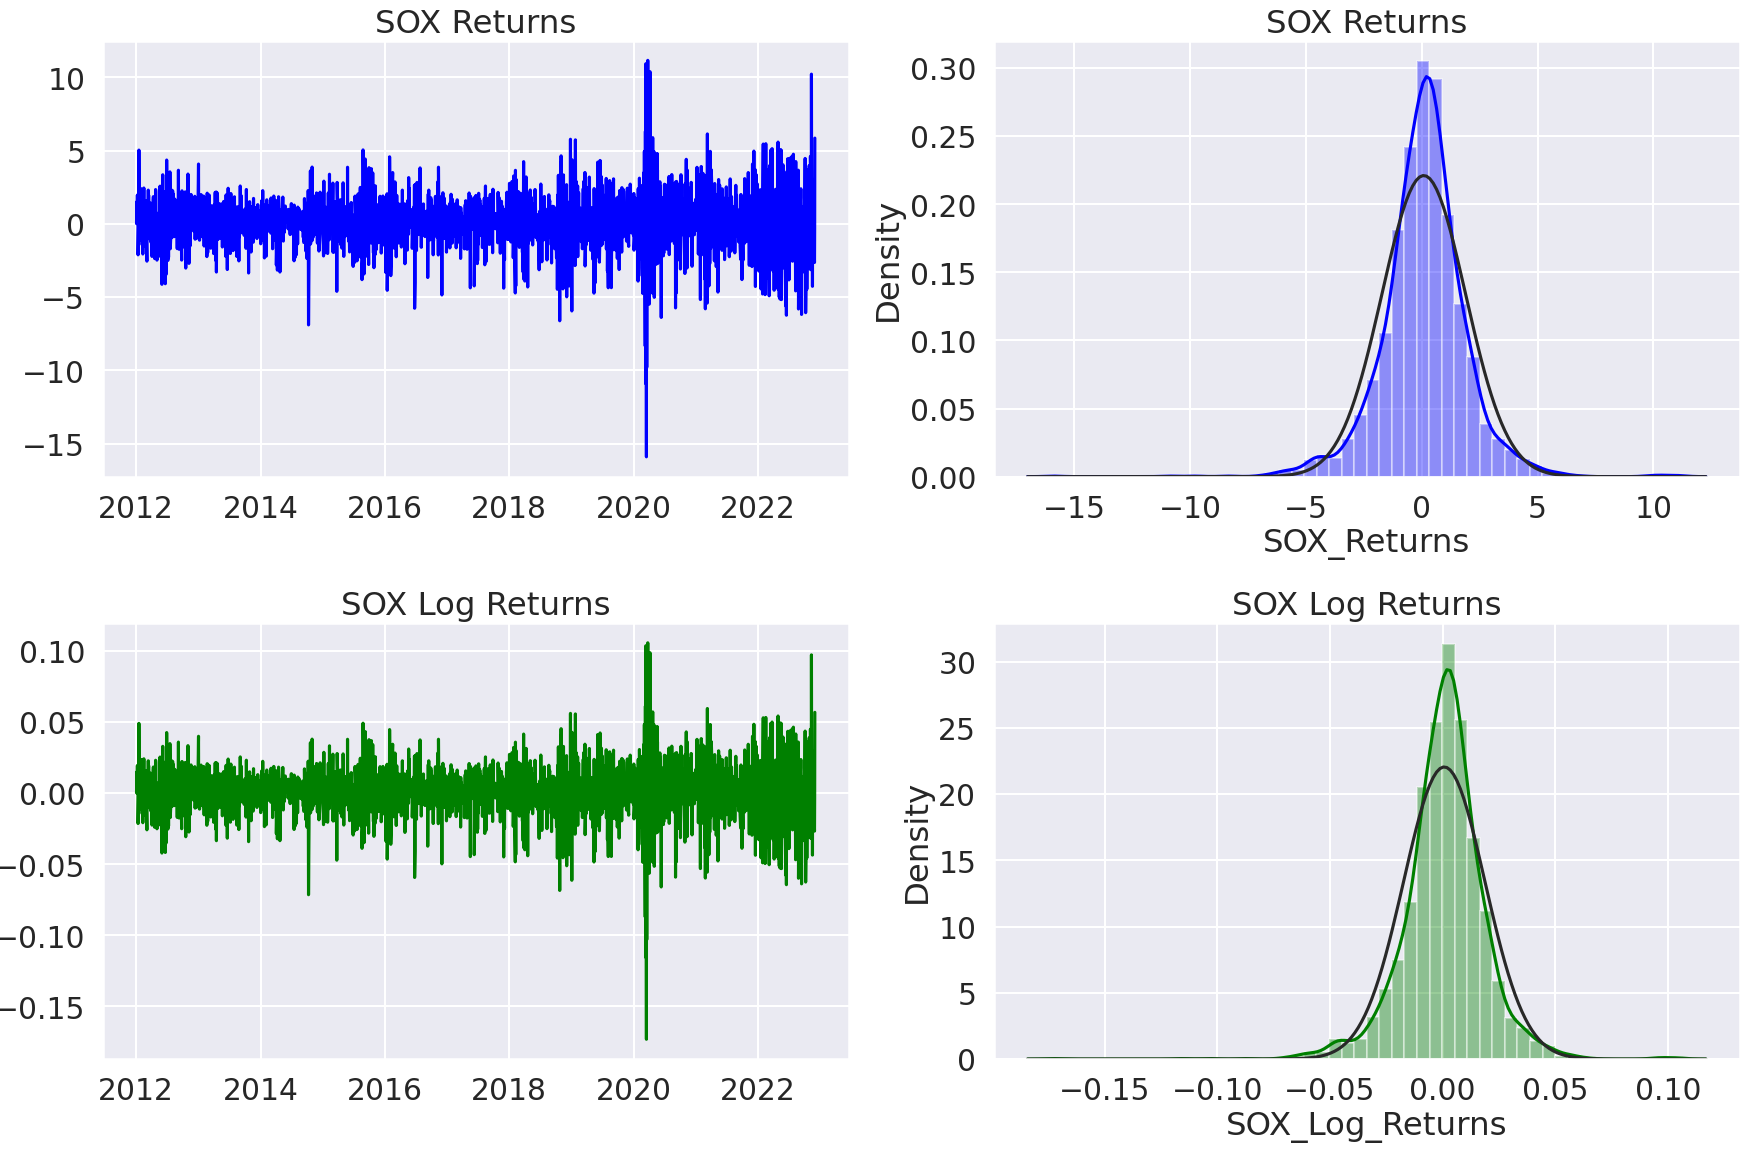

In [25]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.SOX_Returns, color='blue')
    axes[0][0].set_title('SOX Returns')

    sns.distplot(df.SOX_Returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('SOX Returns')

    axes[1][0].plot(df.SOX_Log_Returns, color='green')
    axes[1][0].set_title('SOX Log Returns')

    sns.distplot(df.SOX_Log_Returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('SOX Log Returns')
    plt.tight_layout()
    fig.show()

In [26]:
df.SOX_Returns.describe()

count    2746.000000
mean        0.090576
std         1.804923
min       -15.896286
25%        -0.815781
50%         0.150370
75%         1.025298
max        11.154737
Name: SOX_Returns, dtype: float64

In [27]:
df.SOX_Log_Returns.describe()

count    2746.000000
mean        0.000742
std         0.018099
min        -0.173119
25%        -0.008191
50%         0.001503
75%         0.010201
max         0.105753
Name: SOX_Log_Returns, dtype: float64

In [28]:
# CALCULATE REALIZED VOLATILITY FROM DAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [29]:
# EXPERIMENT WITH DIFFERENT INTERVAL WINDOWS
intervals = [5, 21, 42, 126, 252]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.SOX_Log_Returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

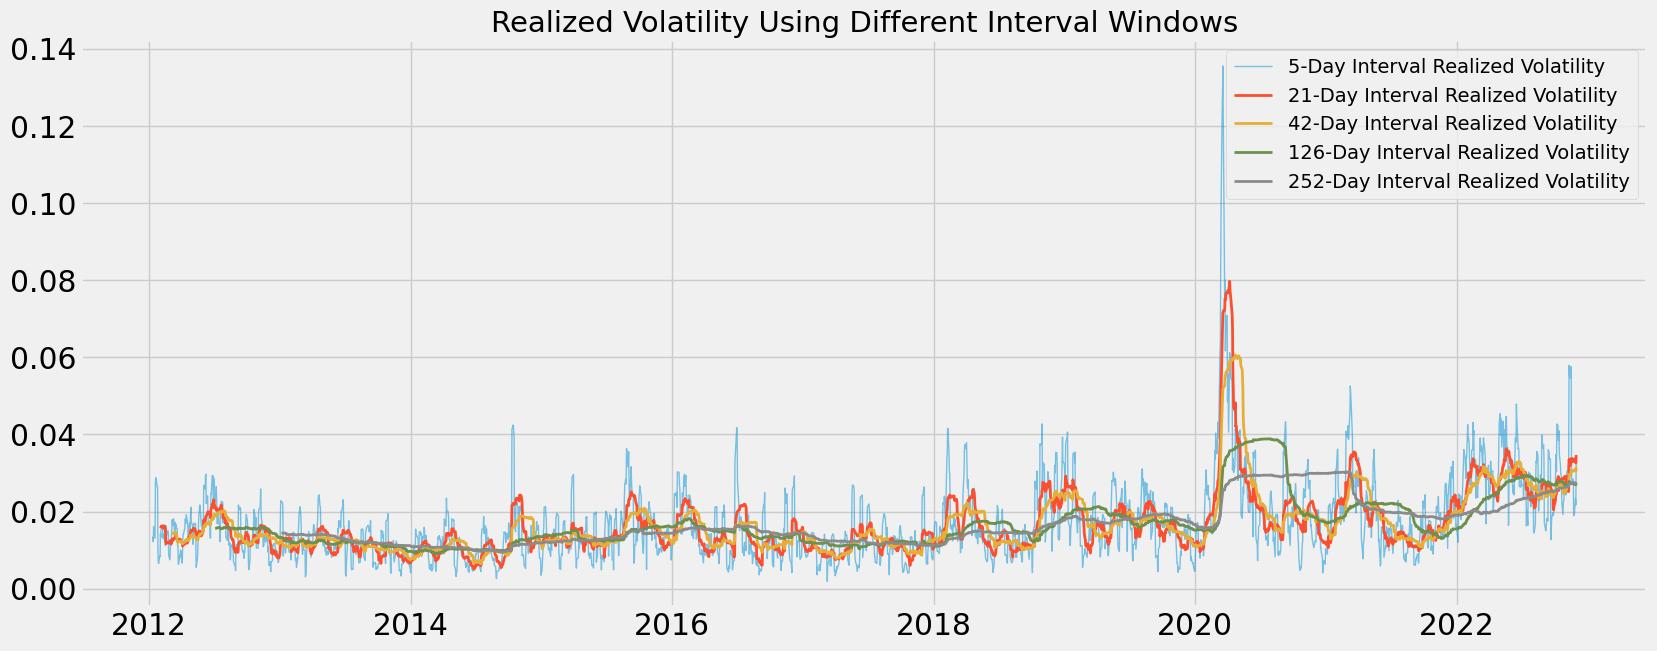

In [30]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 5:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})

plt.show()

In [31]:
INTERVAL_WINDOW = 5
n_future = 5

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['Vol_Current_5d'] = df.SOX_Log_Returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['Vol_Future_5d'] = df.SOX_Log_Returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [32]:
df.describe()

SOX          VIX         VIX2  SOX_Returns  VIX_Returns  \
count  2746.000000  2746.000000  2746.000000  2746.000000  2746.000000   
mean   1359.773110    17.822542   367.694405     0.090576     0.317682   
std     969.450286     7.075990   416.088001     1.804923     8.392999   
min     351.280029     9.140000    83.539606   -15.896286   -25.905673   
25%     614.572495    13.205000   174.372098    -0.815781    -4.341422   
50%    1075.150024    15.905000   252.969042     0.150370    -0.652840   
75%    1794.770020    20.577500   423.433520     1.025298     3.641506   
max    4039.510010    82.690002  6837.636504    11.154737   115.597925   

       VIX2_Returns  SOX_Log_Returns  VIX_Log_Returns  VIX2_Log_Returns  \
count   2746.000000      2746.000000      2746.000000       2746.000000   
mean       1.340541         0.000742        -0.000040         -0.000080   
std       18.671846         0.018099         0.078798          0.157595   
min      -45.100307        -0.173119        -0.299831         -0.599662   
25%       -8.494364        -0.008191        -0.044385         -0.088770   
50%       -1.301416         0.001503        -0.006550         -0.013100   
75%        7.415618         0.010201         0.035768          0.071535   
max      364.824653         0.105753         0.768245          1.536490   

       Vol_Current_5d  Vol_Future_5d  
count     2742.000000    2737.000000  
mean         0.017141       0.017147  
std          0.010744       0.010753  
min          0.001923       0.001923  
25%          0.010367       0.010366  
50%          0.014531       0.014539  
75%          0.021283       0.021297  
max          0.135543       0.135543

In [33]:
df.dropna(inplace=True)

## **Exploratory Data Analysis**

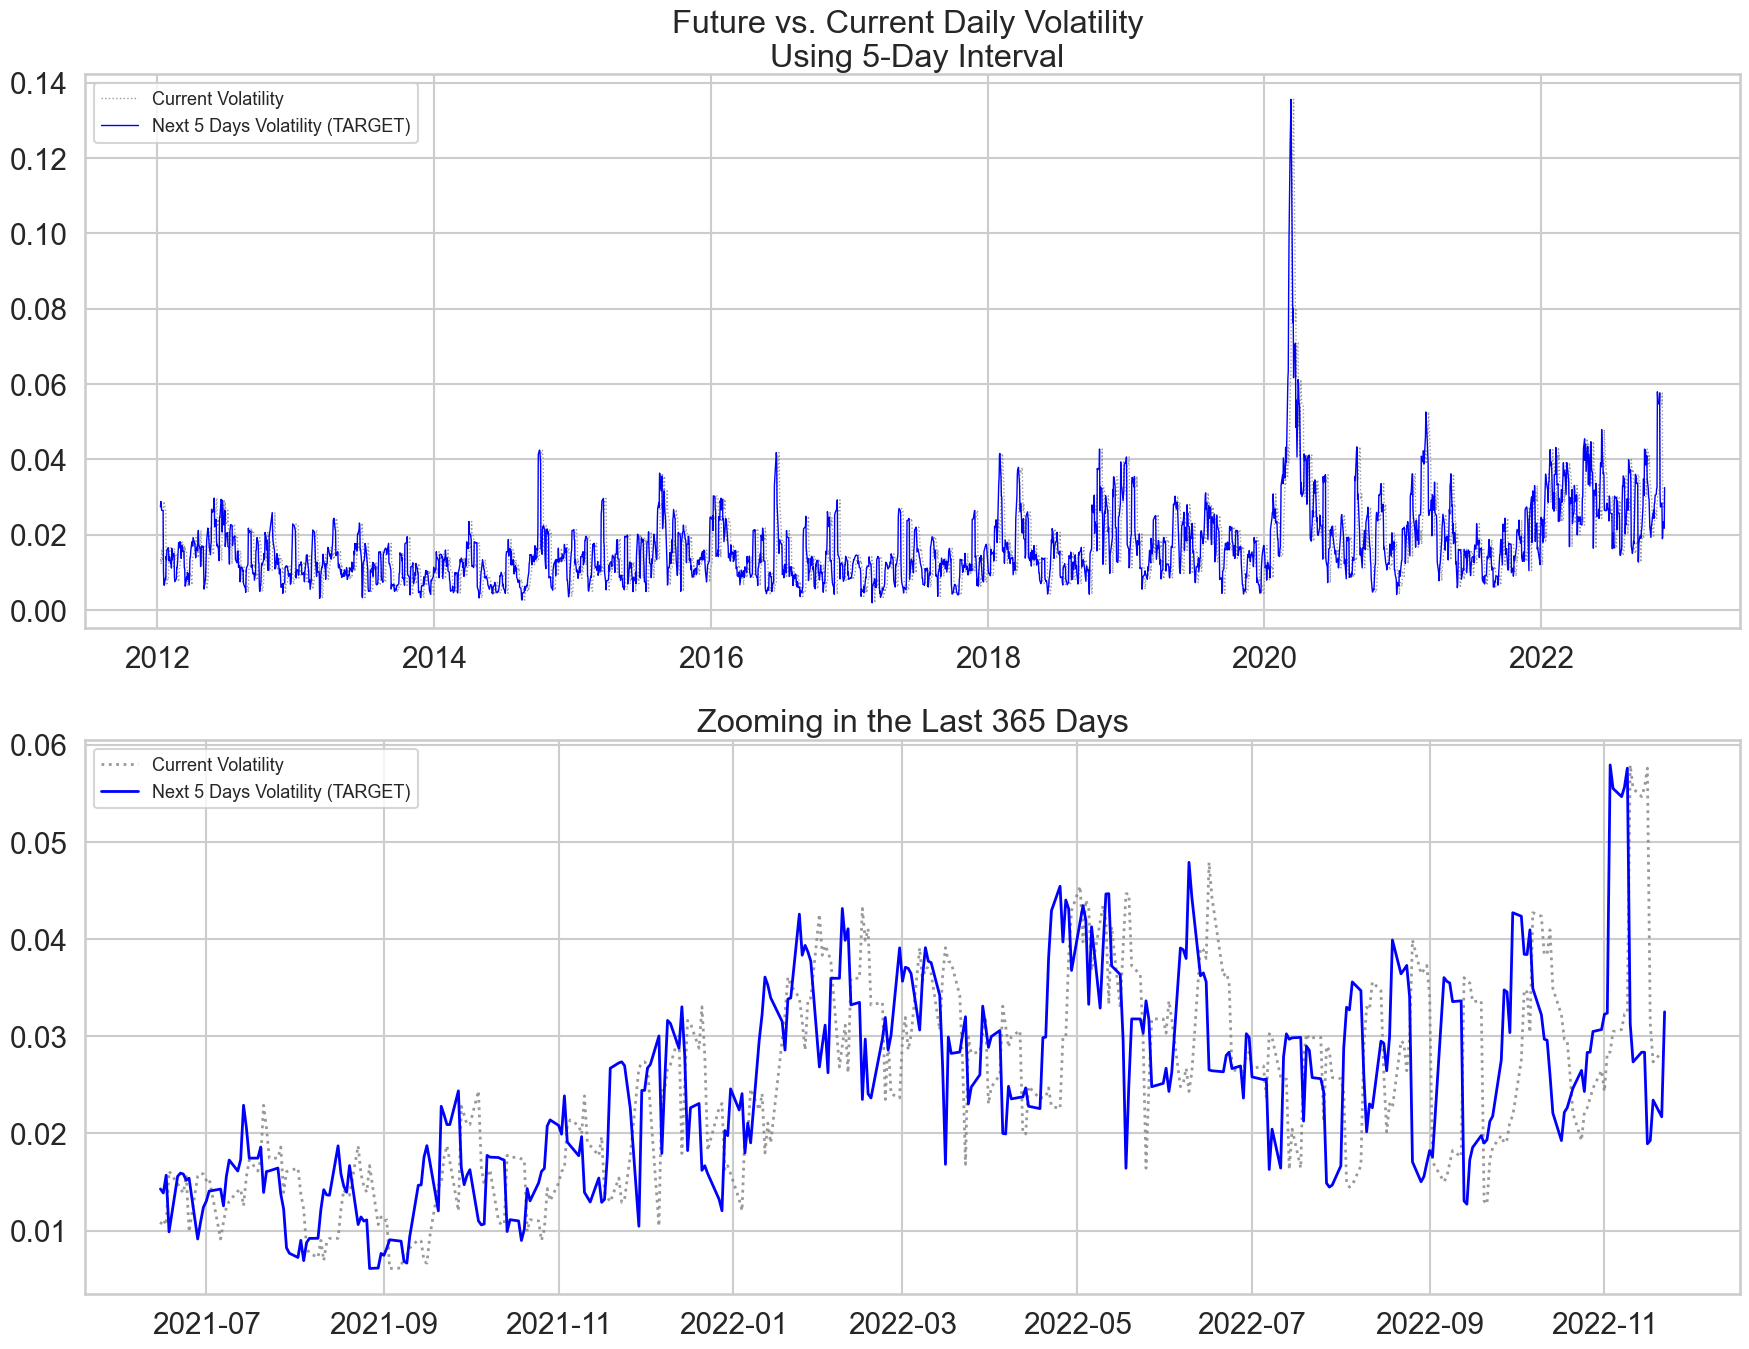

In [34]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.Vol_Current_5d, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.Vol_Future_5d, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.Vol_Current_5d[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.Vol_Future_5d[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()

    plt.show()

### **Daily Volatility Grouped by Month**

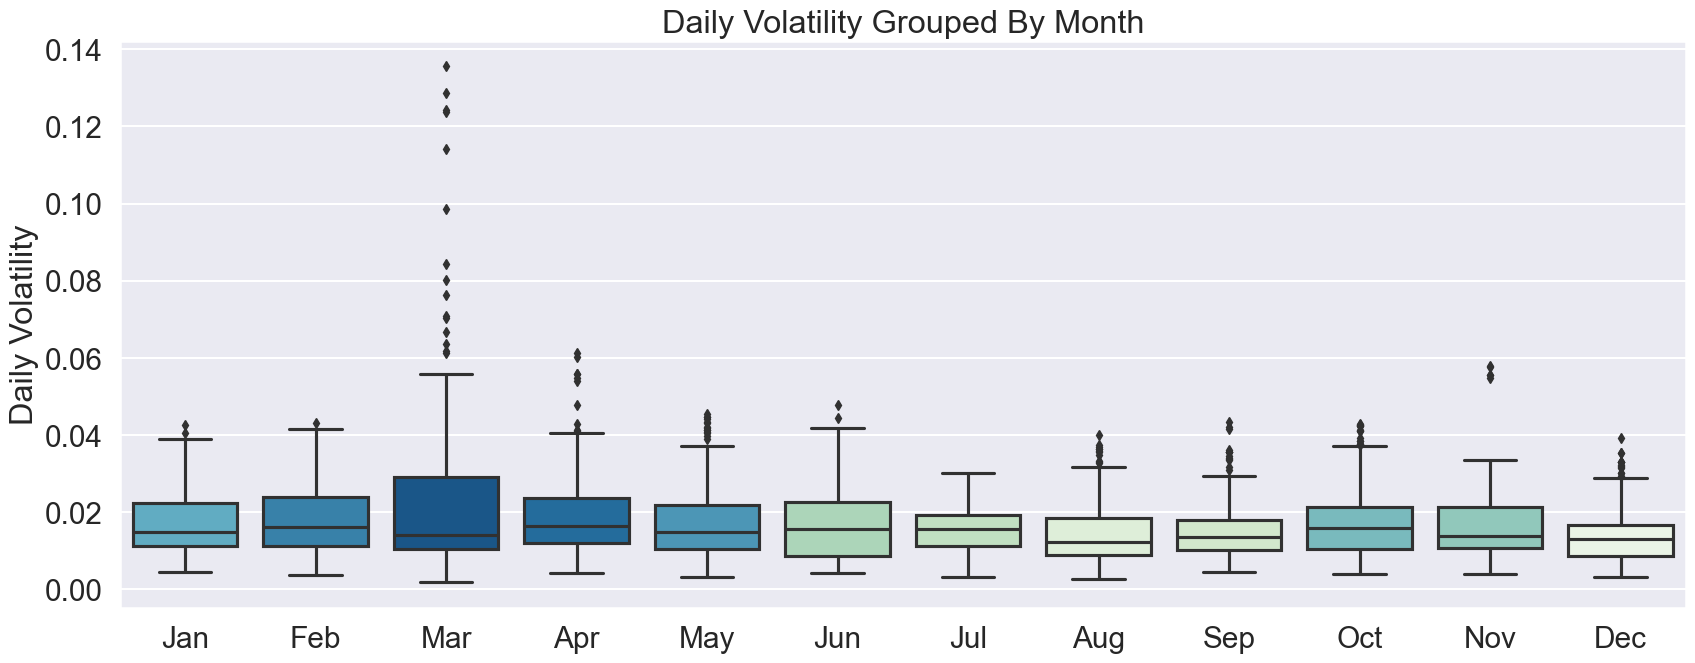

In [35]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
df.index = pd.to_datetime(df.index)
data = df.groupby(by=[df.index.month_name()]).Vol_Current_5d.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.Vol_Current_5d, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.show()

In [36]:
df.Vol_Current_5d.sort_values(ascending=False)[:50]

2020-03-18    0.135543
2020-03-17    0.128723
2020-03-19    0.124360
2020-03-16    0.123716
2020-03-20    0.114181
2020-03-13    0.098529
2020-03-12    0.084363
2020-03-24    0.080080
2020-03-23    0.076270
2020-03-30    0.070827
2020-03-27    0.070295
2020-03-26    0.066724
2020-03-11    0.063490
2020-03-25    0.061647
2020-03-10    0.061325
2020-04-06    0.061178
2020-04-07    0.060160
2022-11-10    0.057914
2022-11-16    0.057583
2020-03-09    0.055897
2020-04-08    0.055761
2020-04-01    0.055706
2022-11-15    0.055639
2022-11-11    0.055495
2022-11-14    0.054653
2020-04-09    0.054652
2020-04-13    0.054001
2021-03-09    0.052562
2021-03-10    0.050959
2021-03-11    0.048827
2020-03-31    0.048474
2022-06-16    0.047897
2020-04-02    0.047792
2021-03-12    0.046614
2021-03-08    0.046090
2022-05-02    0.045435
2022-05-19    0.044669
2022-05-18    0.044647
2022-06-17    0.044304
2022-05-04    0.044017
2022-05-10    0.043445
2020-09-09    0.043314
2020-03-04    0.043185
2022-02-15 

### **Daily Volatility Grouped by Year**

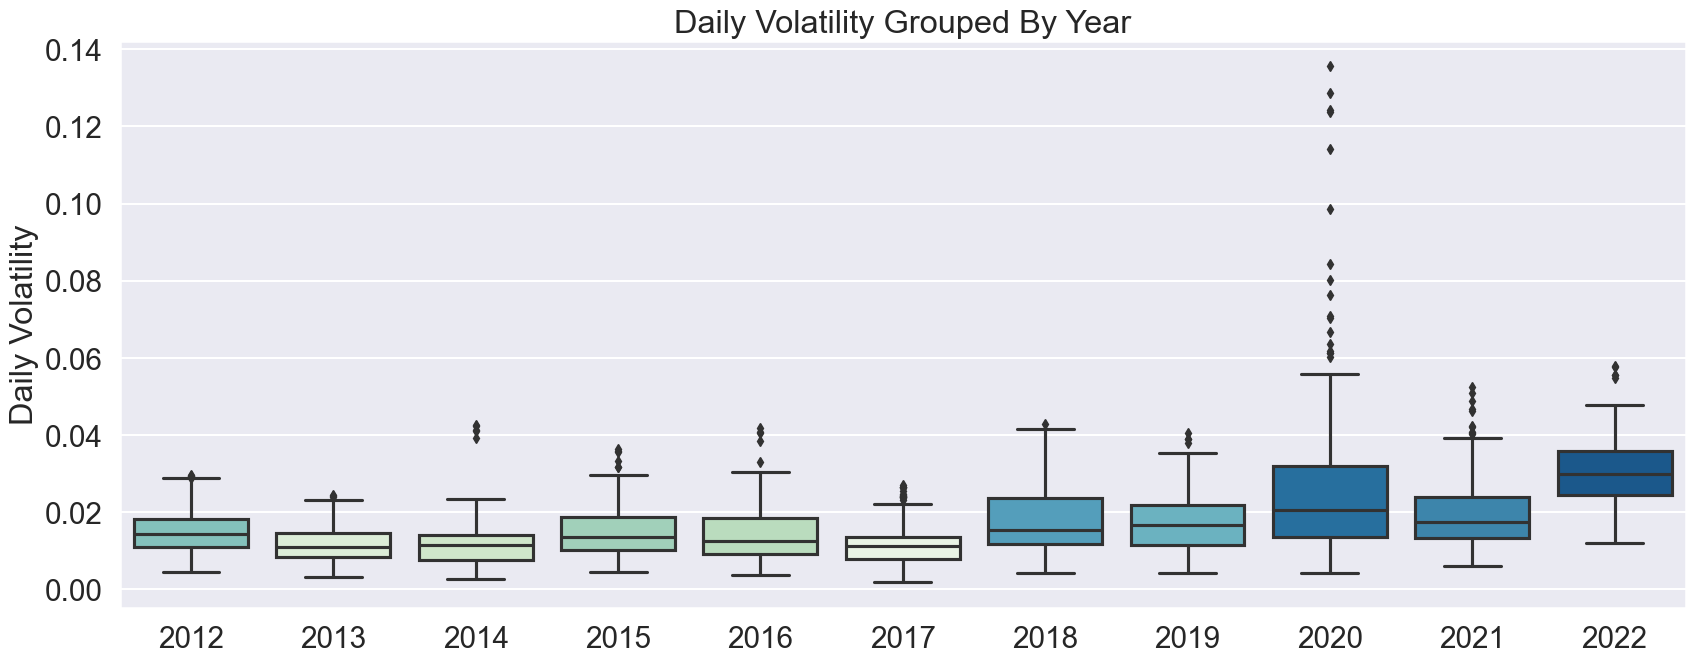

In [37]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).Vol_Current_5d.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.Vol_Current_5d, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.show()

### **Daily Volatility Distribution**

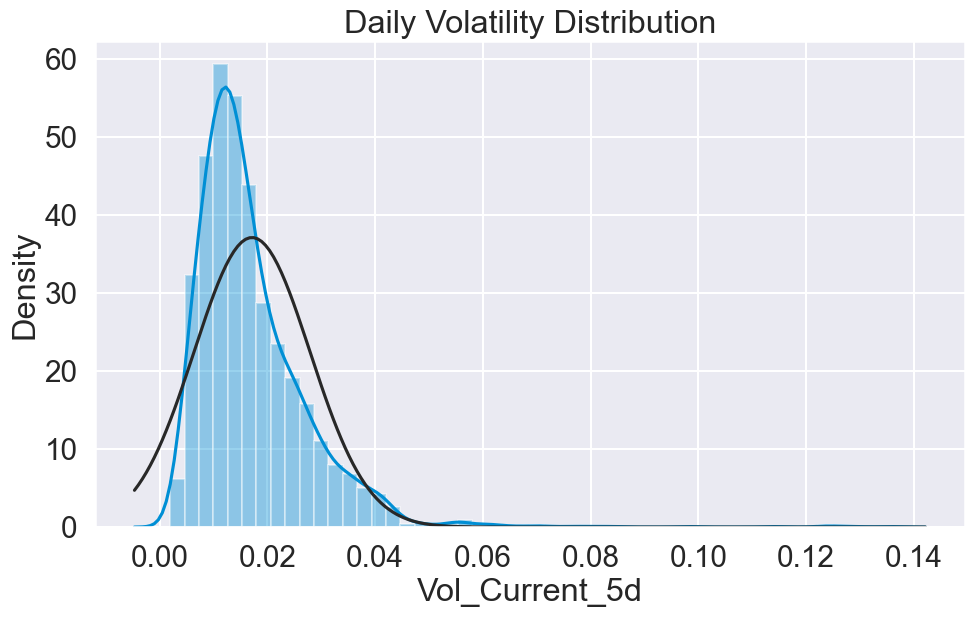

In [38]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.Vol_Current_5d, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show()

### **Returns/Log Returns Stationarity Checking**



In [39]:
from statsmodels.tsa.stattools import adfuller

In [40]:
# LOG RETURNS
adfuller_results = adfuller(df.SOX_Log_Returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -12.017695997472323
p-value: 3.074861464804689e-22
Critical Values:
1%: -3.4328
5%: -2.8626
10%: -2.5673


In [41]:
# RETURNS
adfuller_results = adfuller(df.SOX_Returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -12.075640552575578
p-value: 2.2936400721916473e-22
Critical Values:
1%: -3.4328
5%: -2.8626
10%: -2.5673


## Train-Validation-Test Splits

In [42]:
# TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [43]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2012-01-10 00:00:00 	to: 2021-04-30 00:00:00 	2342 days
VALIDATION 	From: 2021-05-03 00:00:00 	to: 2022-10-11 00:00:00 	365 days
TEST 		From: 2022-10-12 00:00:00 	to: 2022-11-22 00:00:00 	30 days


In [44]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.Vol_Future_5d[train_idx]
y_val = df.Vol_Future_5d[val_idx]
y_test = df.Vol_Future_5d[test_idx]

In [45]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.Vol_Current_5d[train_idx]
x_val = df.Vol_Current_5d[val_idx]
x_test = df.Vol_Current_5d[test_idx]

In [46]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.SOX_Returns[train_idx]
r_val = df.SOX_Returns[val_idx]
r_test = df.SOX_Returns[test_idx]

In [47]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.SOX_Log_Returns[train_idx]
lr_val = df.SOX_Log_Returns[val_idx]
lr_test = df.SOX_Log_Returns[test_idx]

In [48]:
y_train.describe()

count    2342.000000
mean        0.015939
std         0.010363
min         0.001923
25%         0.009883
50%         0.013615
75%         0.019339
max         0.135543
Name: Vol_Future_5d, dtype: float64

In [49]:
x_train.describe()

count    2342.000000
mean        0.015931
std         0.010363
min         0.001923
25%         0.009883
50%         0.013578
75%         0.019331
max         0.135543
Name: Vol_Current_5d, dtype: float64

## Data Preprocessing

### Feature Normalization

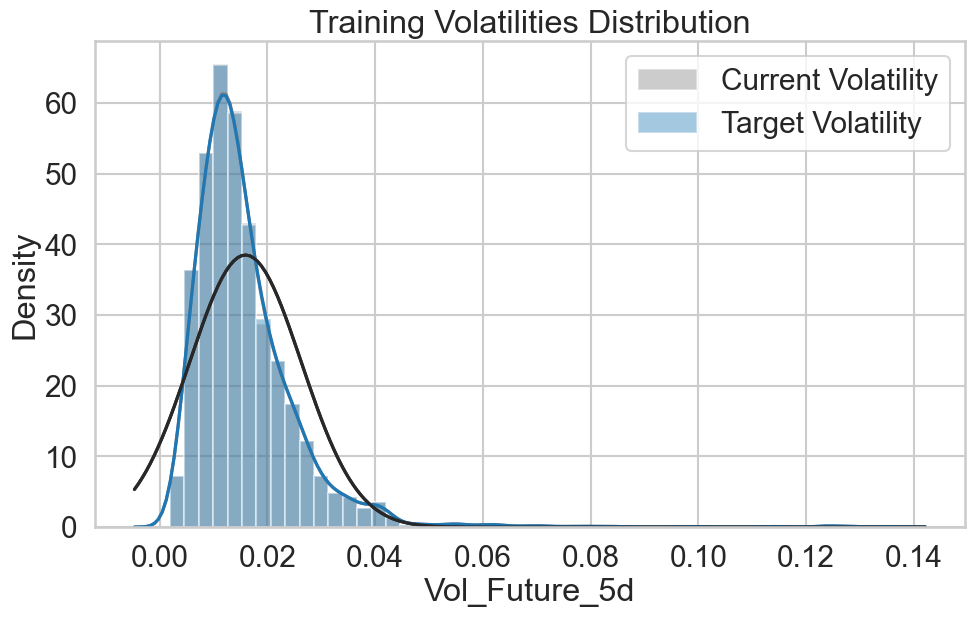

In [50]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.show()

In [51]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [52]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [53]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [54]:
x_train.head(10)

2012-01-10    0.013214
2012-01-11    0.013377
2012-01-12    0.012183
2012-01-13    0.016142
2012-01-17    0.013082
2012-01-18    0.027394
2012-01-19    0.028821
2012-01-20    0.028521
2012-01-23    0.026488
2012-01-24    0.026448
Name: Vol_Current_5d, dtype: float64

In [55]:
y_train.head(10)

2012-01-10    0.027394
2012-01-11    0.028821
2012-01-12    0.028521
2012-01-13    0.026488
2012-01-17    0.026448
2012-01-18    0.010123
2012-01-19    0.006896
2012-01-20    0.006569
2012-01-23    0.008496
2012-01-24    0.008317
Name: Vol_Future_5d, dtype: float64

In [56]:
x_train_scaled.head(10)

2012-01-10    0.084503
2012-01-11    0.085719
2012-01-12    0.076785
2012-01-13    0.106411
2012-01-17    0.083515
2012-01-18    0.190623
2012-01-19    0.201305
2012-01-20    0.199056
2012-01-23    0.183845
2012-01-24    0.183546
dtype: float64

In [57]:
y_train_scaled.head(10)

2012-01-10    0.190623
2012-01-11    0.201305
2012-01-12    0.199056
2012-01-13    0.183845
2012-01-17    0.183546
2012-01-18    0.061369
2012-01-19    0.037219
2012-01-20    0.034772
2012-01-23    0.049193
2012-01-24    0.047853
dtype: float64

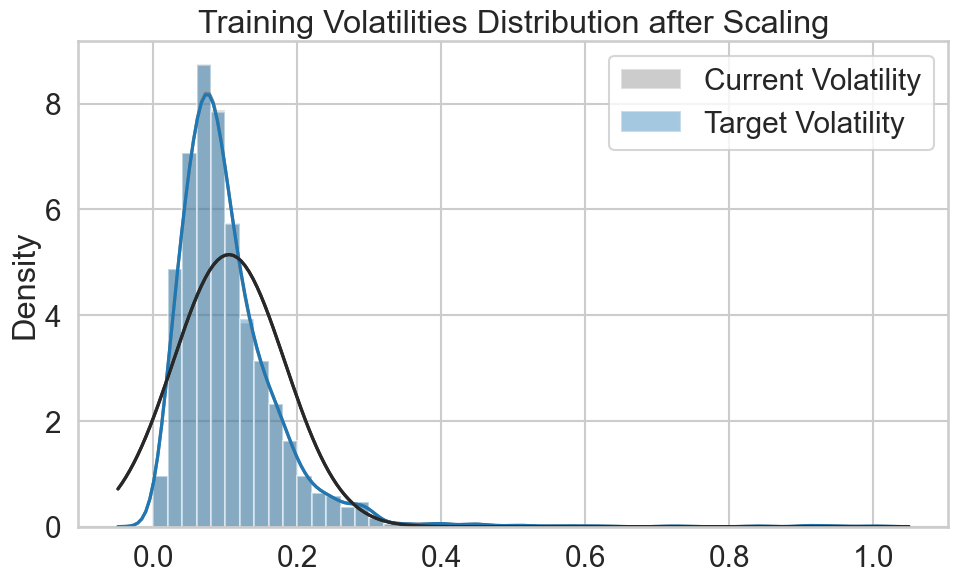

In [58]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show()

### Train-Validation-Test Visualization

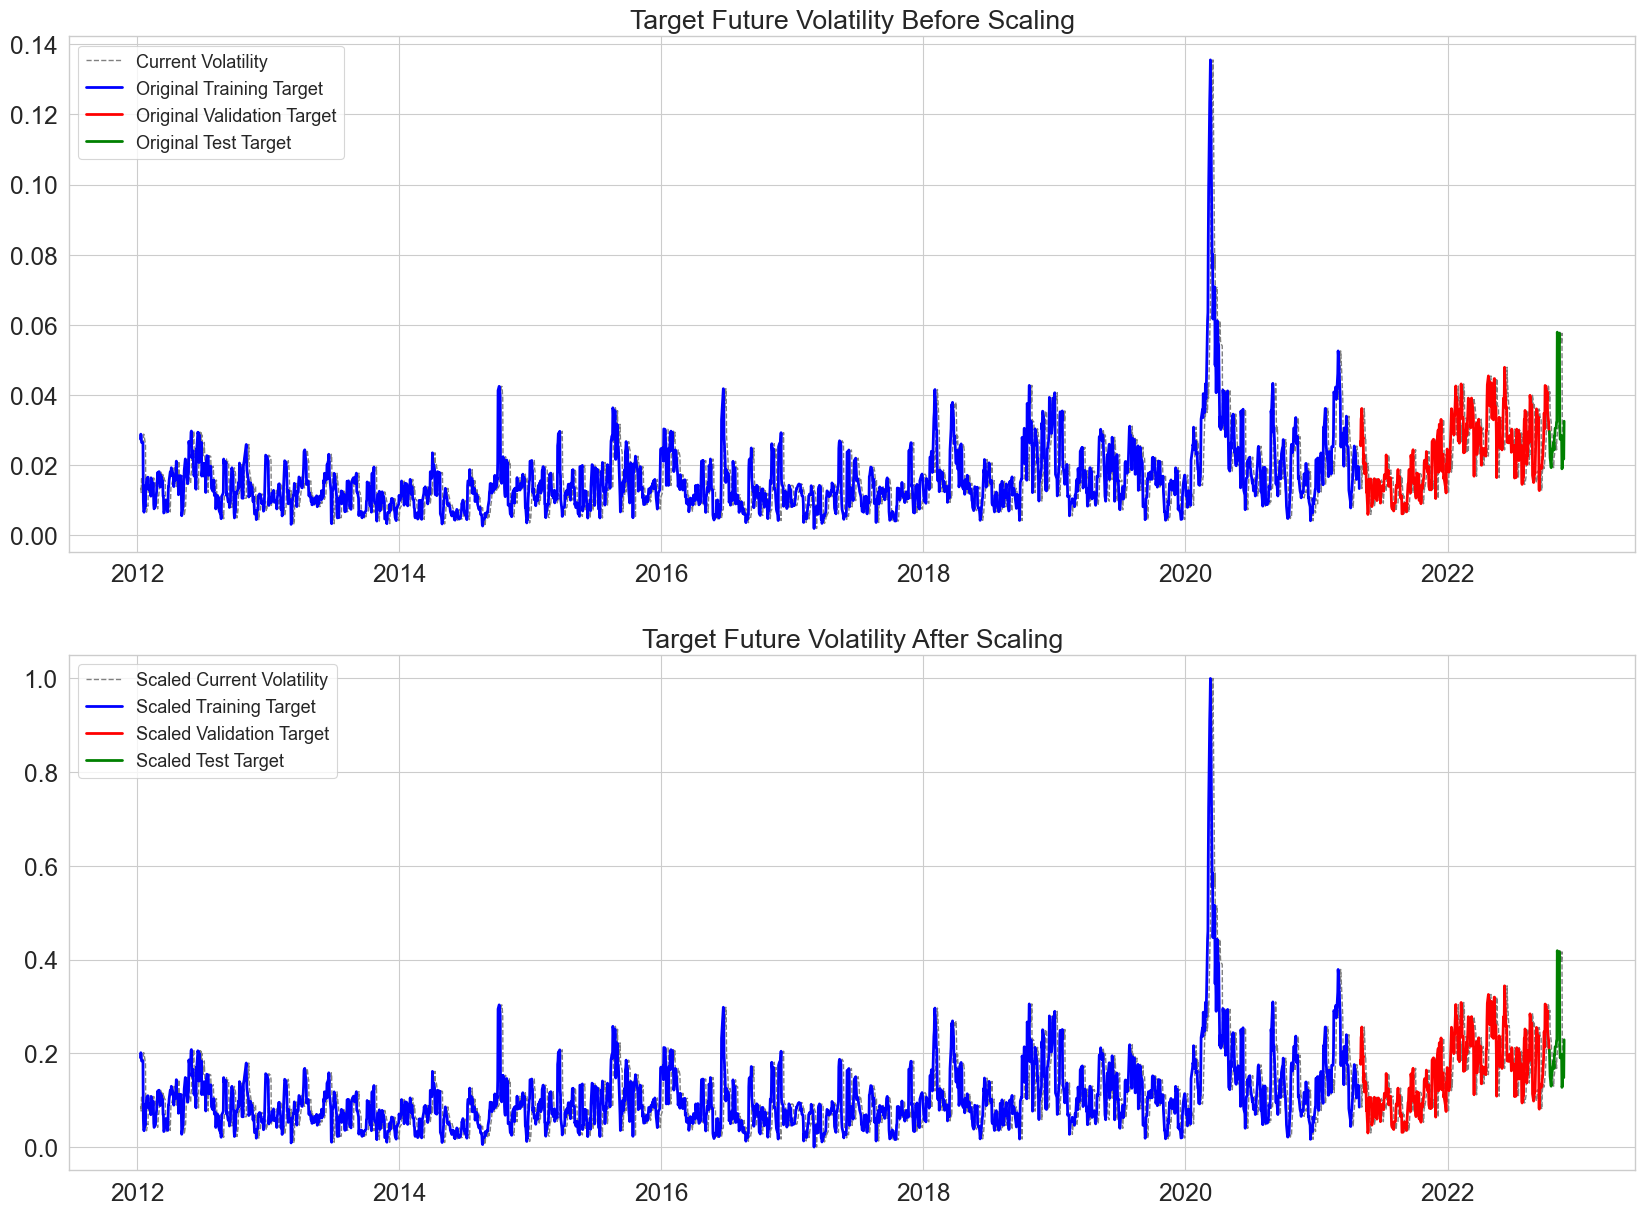

In [59]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.Vol_Current_5d, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='red', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.Vol_Current_5d), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='red', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show()

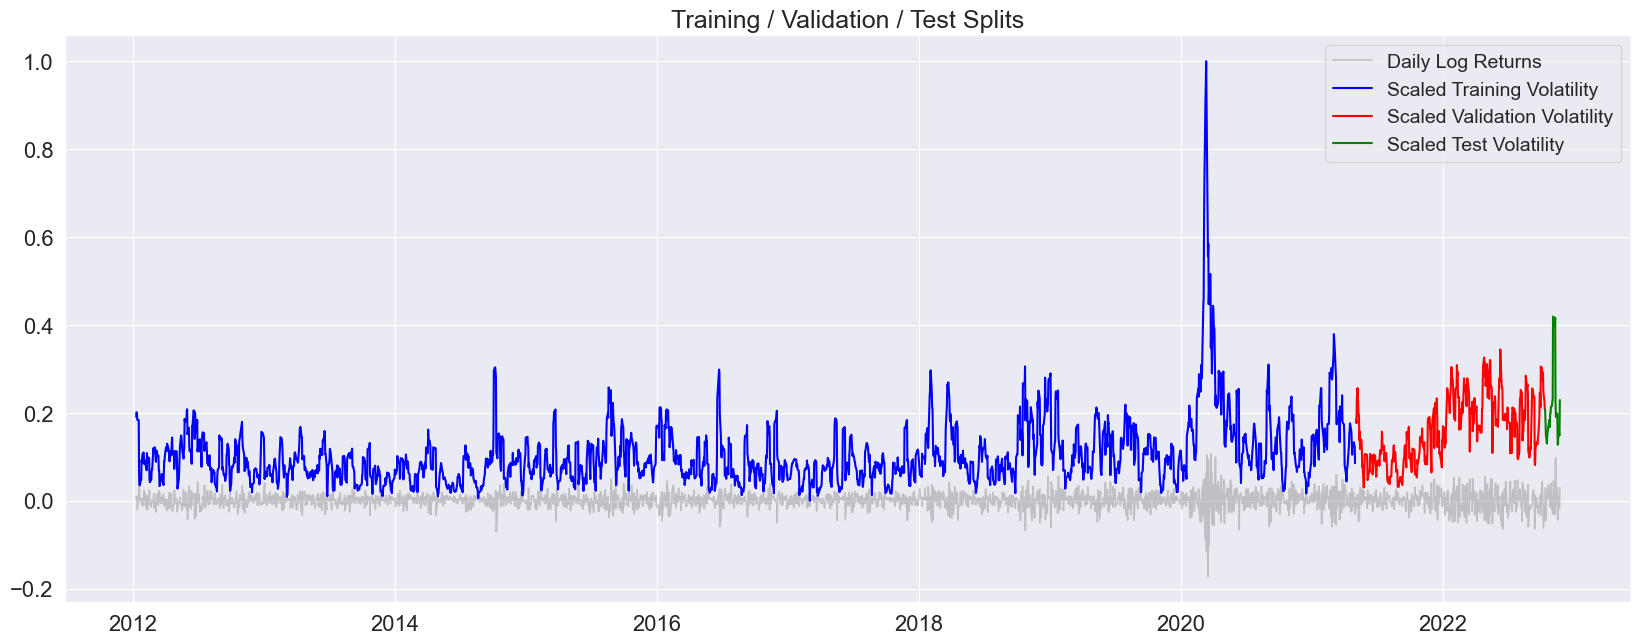

In [60]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.SOX_Log_Returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=18)
    plt.legend(prop={'size': 14}, frameon=True)
    plt.show()

# Modeling

## 1. Performance Metrics

The three main metrics we will using are **RMSPE (Root Mean Squared Percentage Error)**, **RMSE (Root Mean Square Errors)** and **R2 (R-squared)**.
RMSE, RMSPE and R2 would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [61]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [62]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [63]:
# DEFINE R-SQUARED FUNCTION
def R_Squared(y_true, y_pred):
    """
    Compute R-squared between 2 arrays
    """
    output = r2(y_true, y_pred)
    return output

In [64]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE', 'Validation R2'])

In [65]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE, RMPSE and R2 INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred),
                                       R_Squared(y_true, y_pred)]
    return perf_df

In [66]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

# 2. Baseline Models
## 2.1 Mean Baseline

In [67]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.1048329987080483

In [68]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

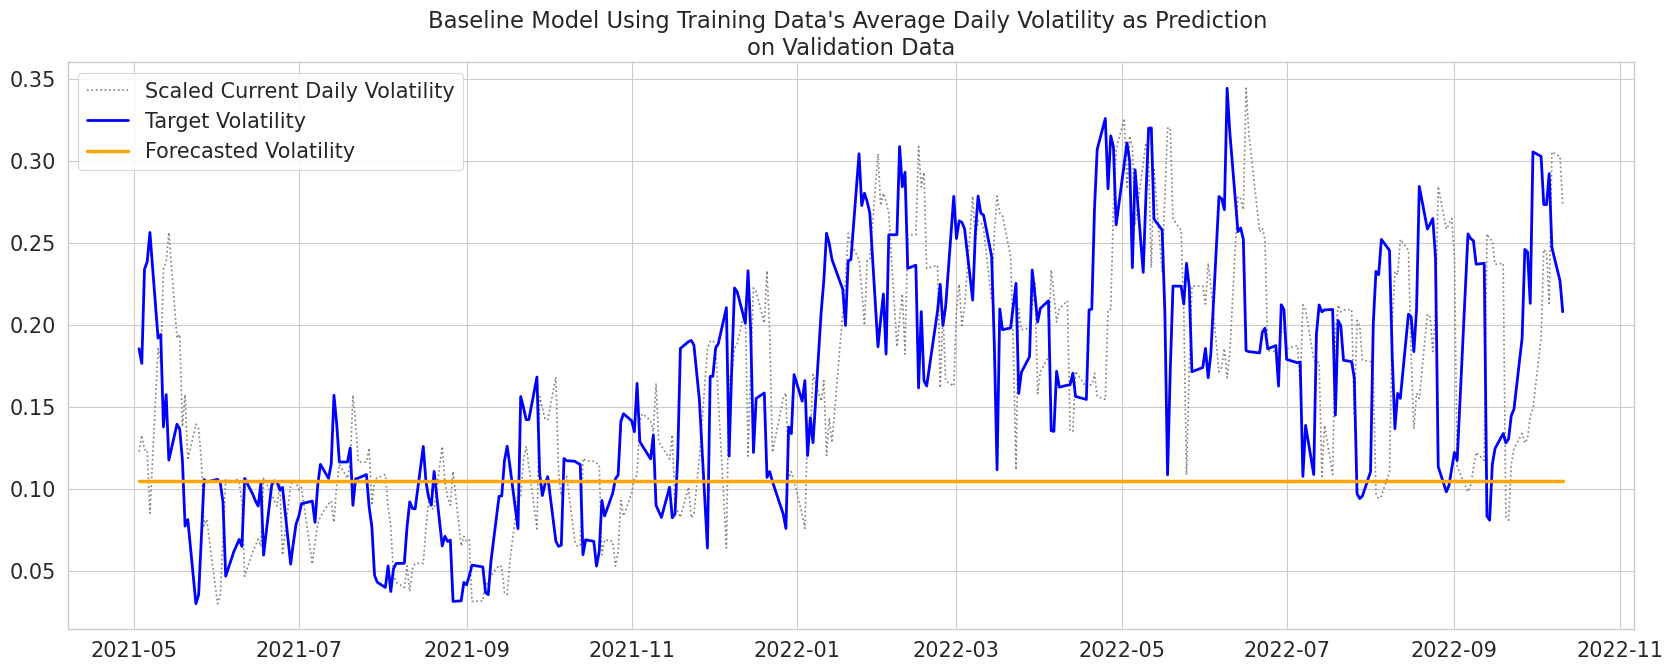

In [69]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.show()

In [70]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE  Validation R2
0  Mean Baseline          0.564868         0.094146      -0.627776

## 2.2 Random Walk Naive Forecasting

In [71]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

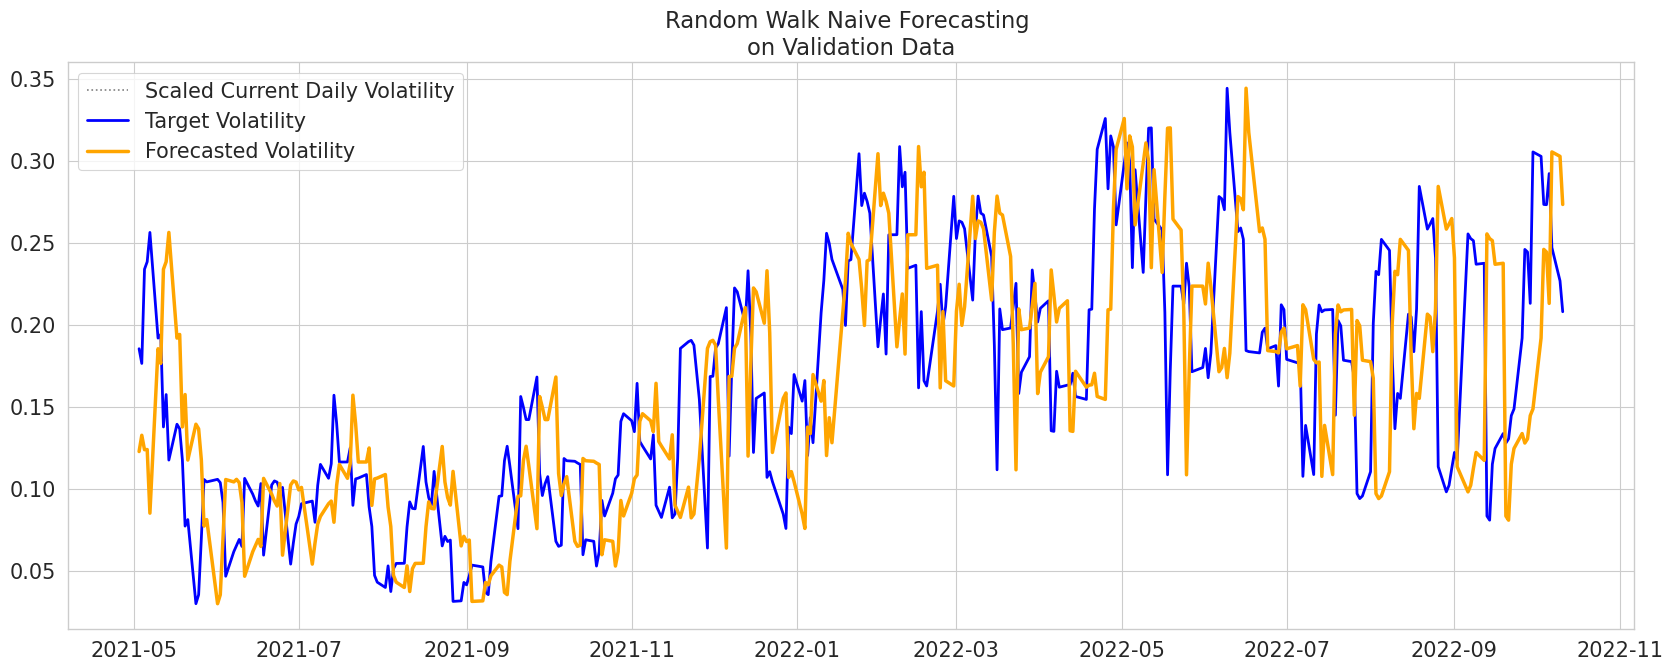

In [72]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show()

In [73]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE  \
0                  Mean Baseline          0.564868         0.094146   
1  Random Walk Naive Forecasting          0.602310         0.070471   

   Validation R2  
0      -0.627776  
1       0.087971

# 3. GARCH Models

## 3.1 Basic GARCH

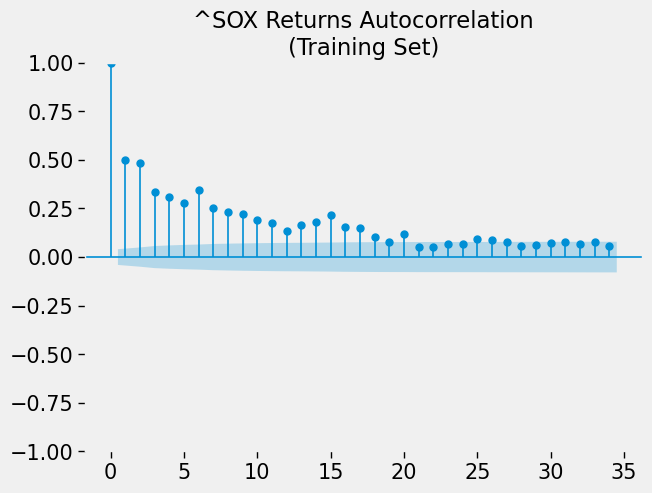

In [74]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr_SOX.upper()} Returns Autocorrelation\n(Training Set)');

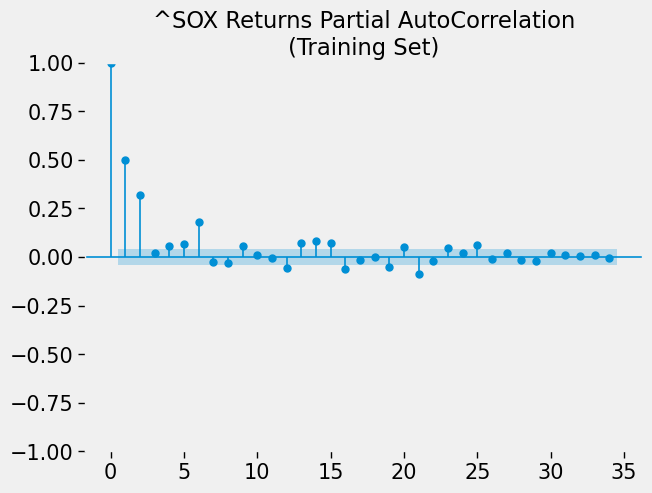

In [75]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr_SOX.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [76]:
from arch import arch_model

In [77]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            SOX_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4212.94
Distribution:                  Normal   AIC:                           8457.88
Method:            Maximum Likelihood   BIC:                           8550.02
                                        No. Observations:                 2342
Date:                Wed, Apr 24 2024   Df Residuals:                     2341
Time:                        12:31:12   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1213  2.747e-02      4.414  1.013e-05 [6.742e-

In [78]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            SOX_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4217.19
Distribution:                  Normal   AIC:                           8442.38
Method:            Maximum Likelihood   BIC:                           8465.41
                                        No. Observations:                 2342
Date:                Wed, Apr 24 2024   Df Residuals:                     2341
Time:                        12:31:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1182  2.802e-02      4.219  2.456e-05 [6.330e-

In [79]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [80]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [81]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show()

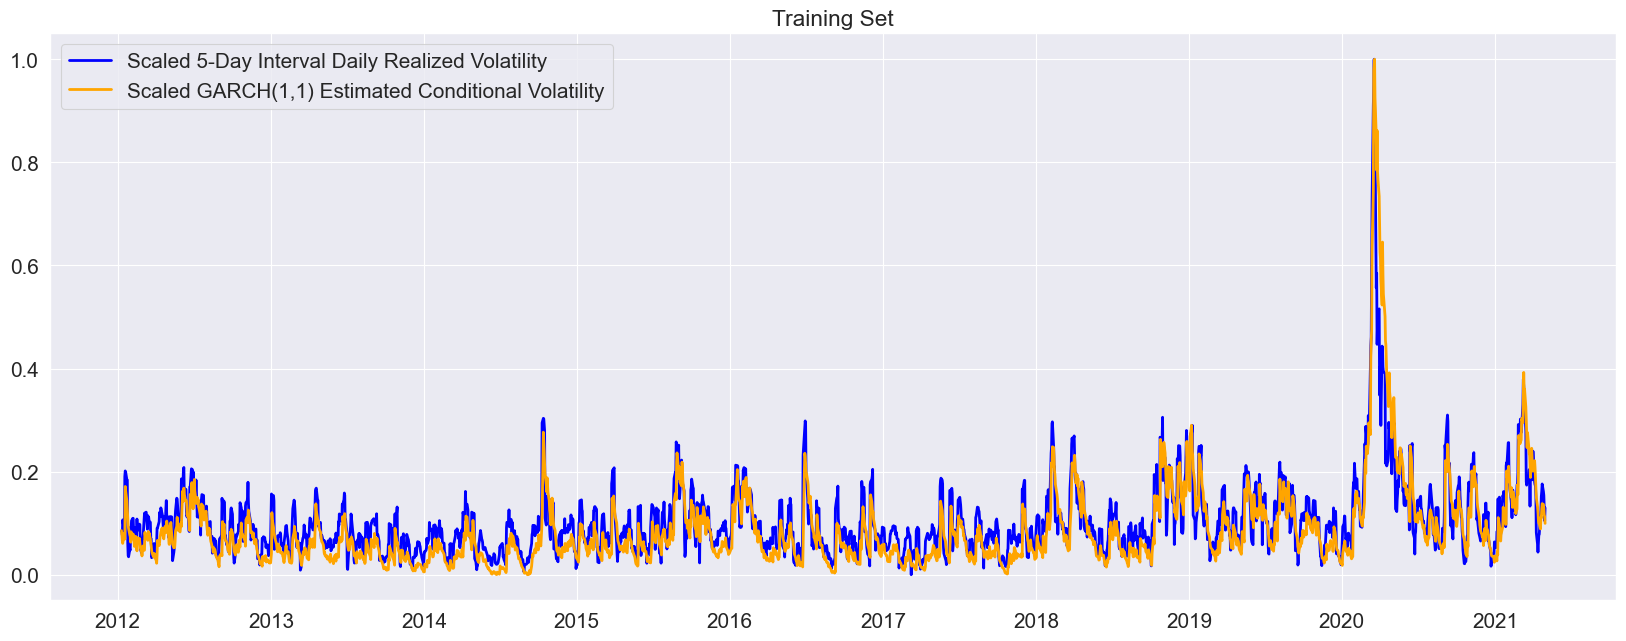

In [82]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

In [83]:
# ONE STEP EXPANDING WINDOW FORECAST
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [84]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

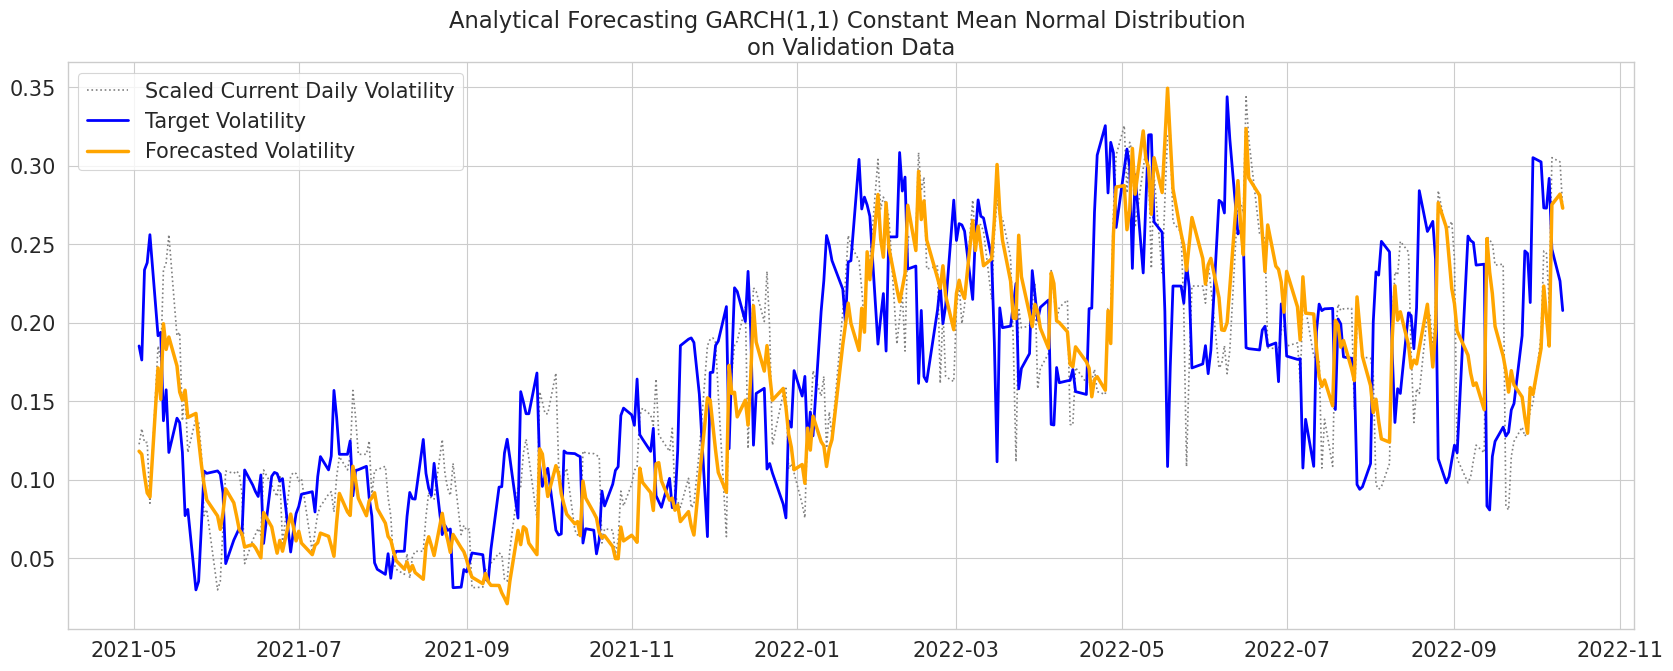

In [85]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [86]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE  \
0                           Mean Baseline          0.564868         0.094146   
1           Random Walk Naive Forecasting          0.602310         0.070471   
2  GARCH(1,1), Constant Mean, Normal Dist          0.534677         0.066675   

   Validation R2  
0      -0.627776  
1       0.087971  
2       0.183565

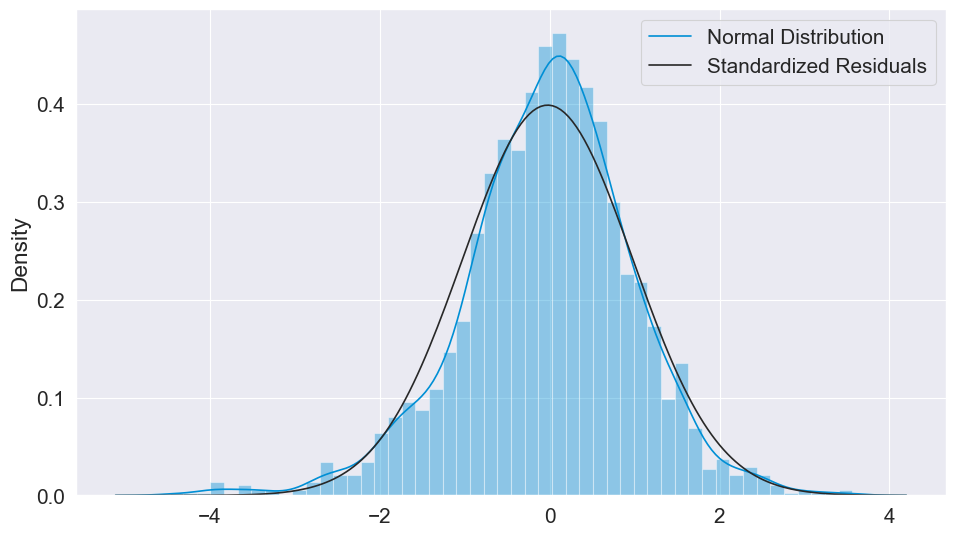

In [87]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show()

## 3.2 GARCH Model with Asymmetric Shocks Responses

In [88]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                       SOX_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -4149.94
Distribution:      Standardized Skew Student's t   AIC:                           8313.88
Method:                       Maximum Likelihood   BIC:                           8354.19
                                                   No. Observations:                 2342
Date:                           Wed, Apr 24 2024   Df Residuals:                     2341
Time:                                   12:31:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [89]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

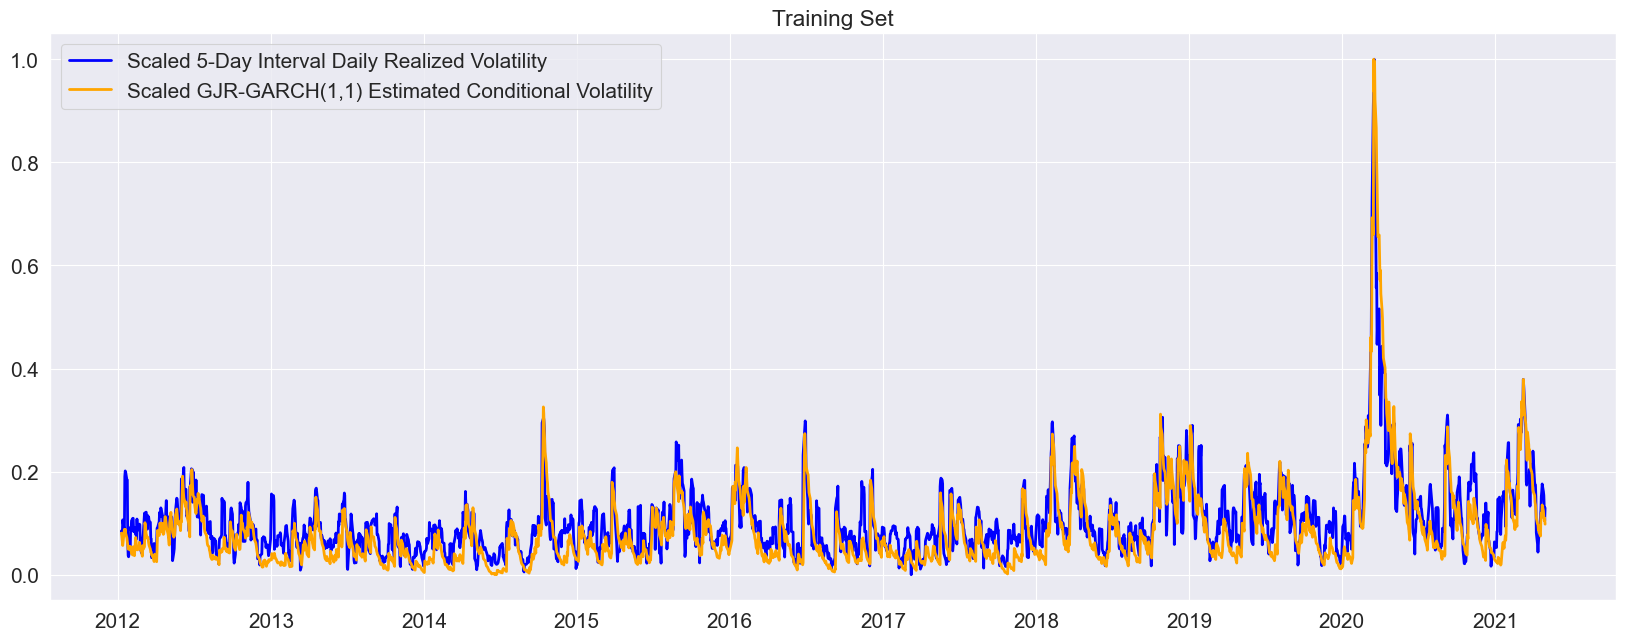

In [90]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [91]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [92]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

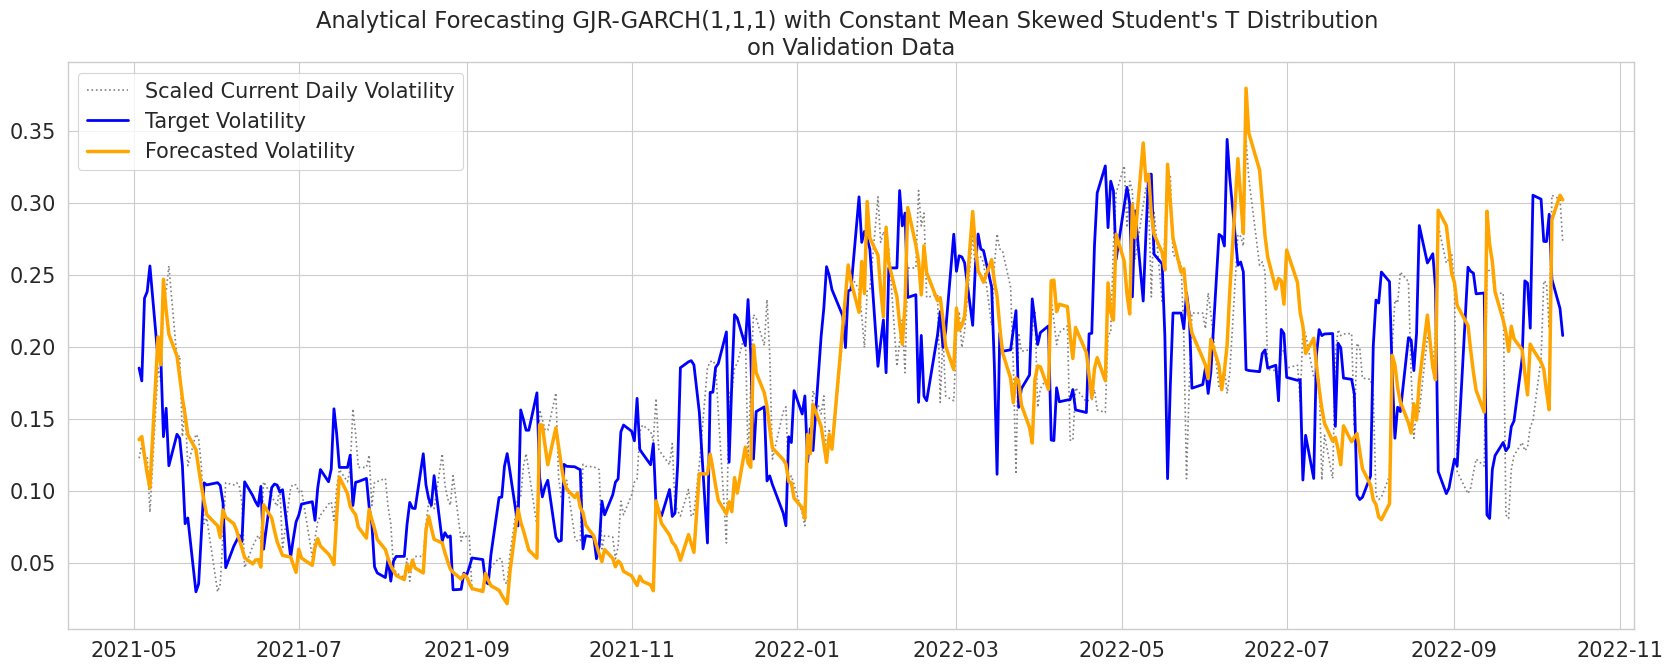

In [93]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [94]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548

## 3.3 TARCH

In [95]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                       SOX_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -4135.89
Distribution:      Standardized Skew Student's t   AIC:                           8285.78
Method:                       Maximum Likelihood   BIC:                           8326.09
                                                   No. Observations:                 2342
Date:                           Wed, Apr 24 2024   Df Residuals:                     2341
Time:                                   12:31:42   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [96]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

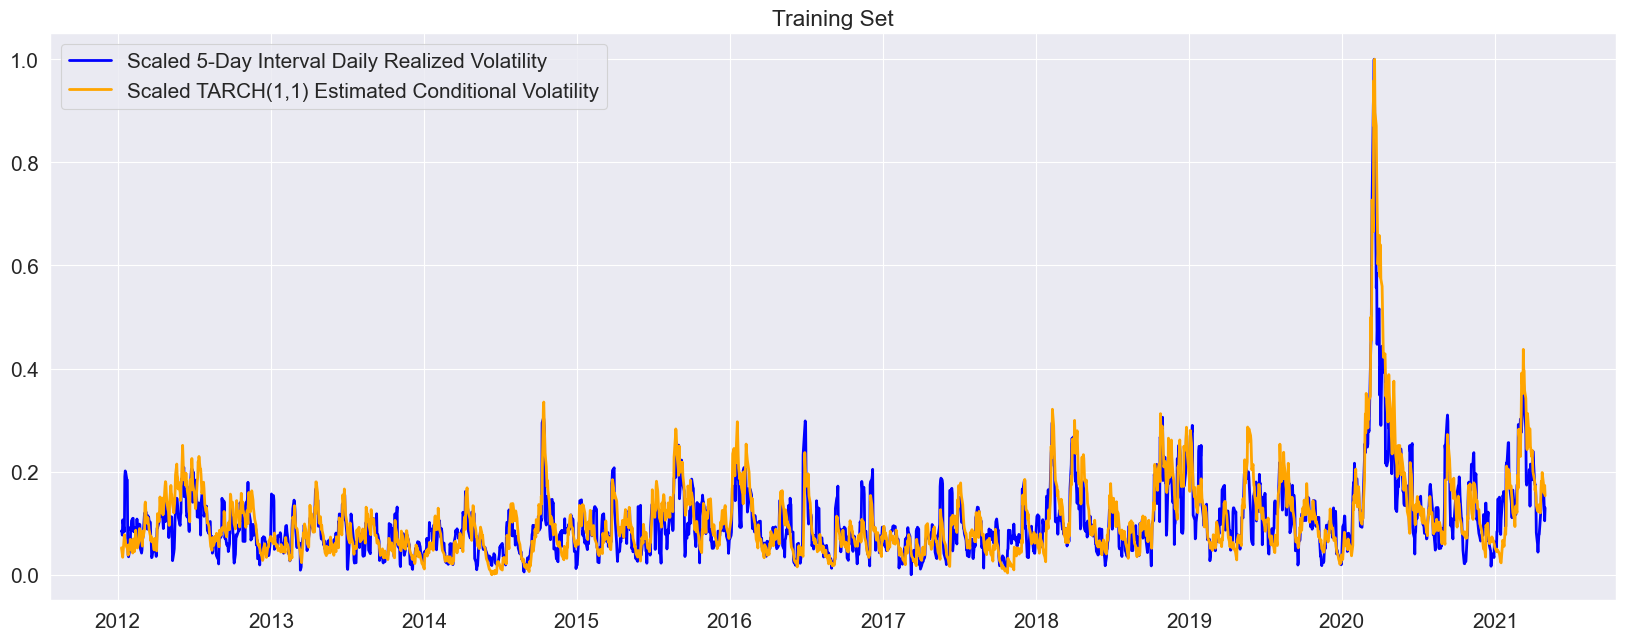

In [97]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

In [98]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [99]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

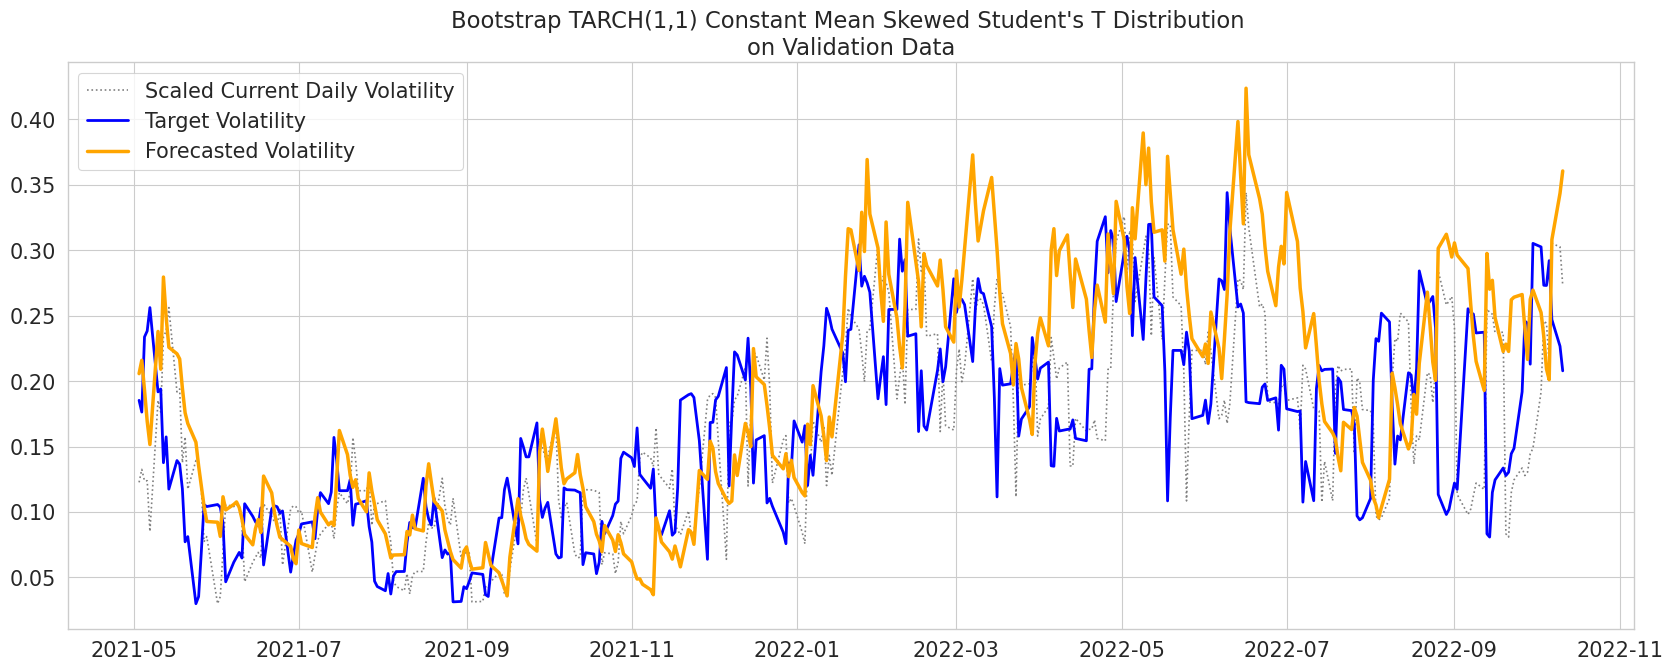

In [100]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [101]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.640507   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548  
4         0.076331      -0.070027

### 3.3.2 Simulation-based Forecasting for TARCH(1,1)

In [102]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [103]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

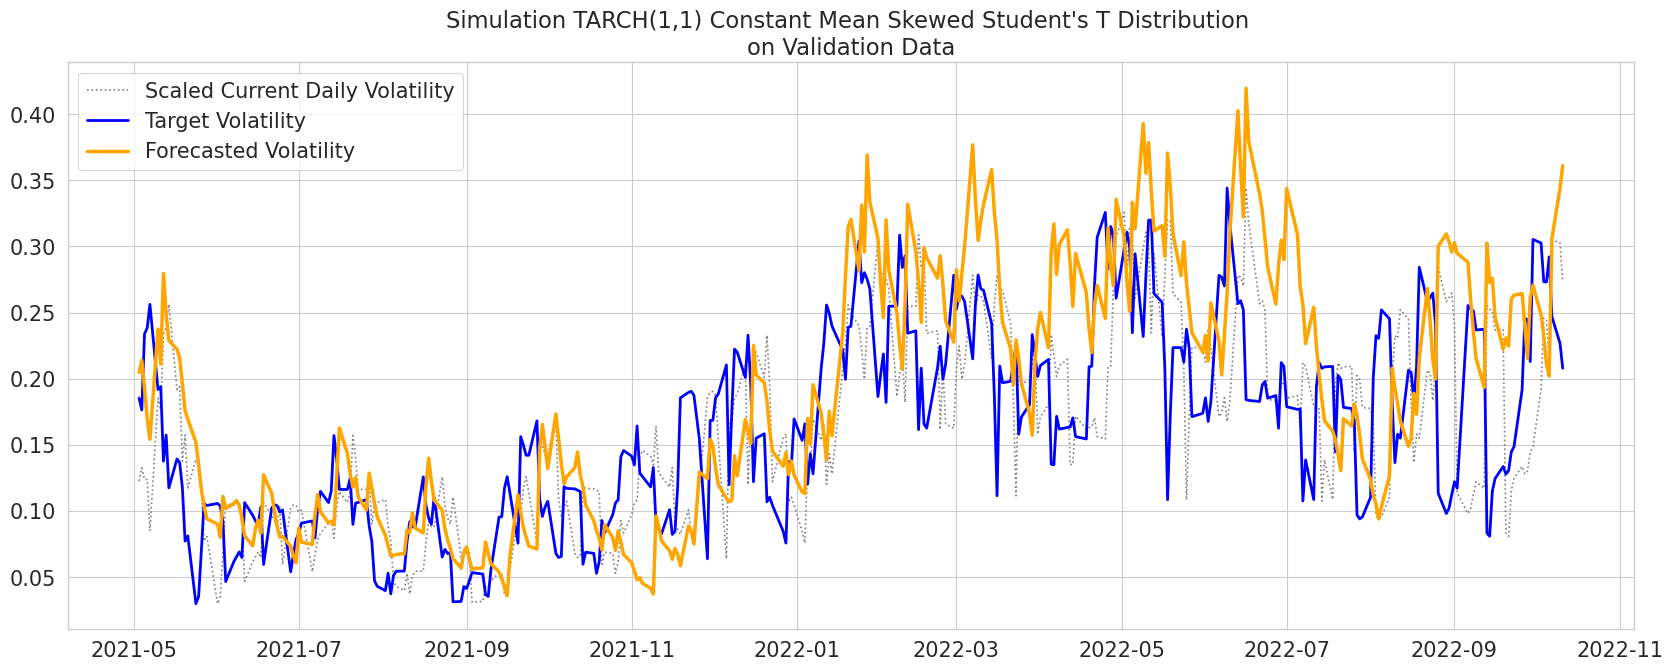

In [104]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [105]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.640507   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.641632   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548  
4         0.076331      -0.070027  
5         0.076586      -0.077172

### 3.3.3. Hyperparameter Tuning for TARCH

In [106]:
import itertools

In [107]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.SOX_Returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [108]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.49007813398149763 using TARCH(2, 0, 1)


In [109]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

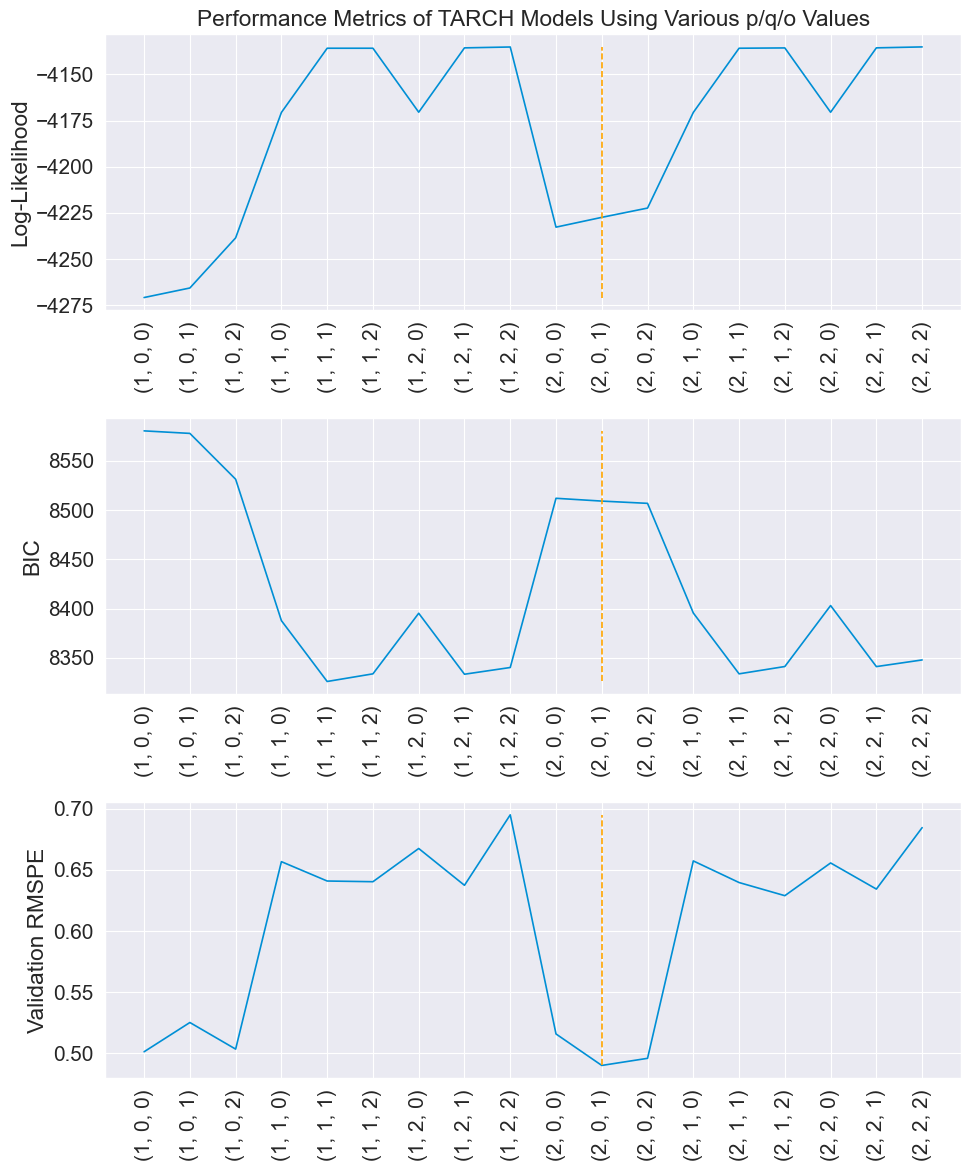

In [110]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    

### 3.4. Final GARCH Model - TARCH(1,2)

In [111]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                       SOX_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -4227.40
Distribution:      Standardized Skew Student's t   AIC:                           8468.79
Method:                       Maximum Likelihood   BIC:                           8509.10
                                                   No. Observations:                 2342
Date:                           Wed, Apr 24 2024   Df Residuals:                     2341
Time:                                   12:40:32   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [112]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

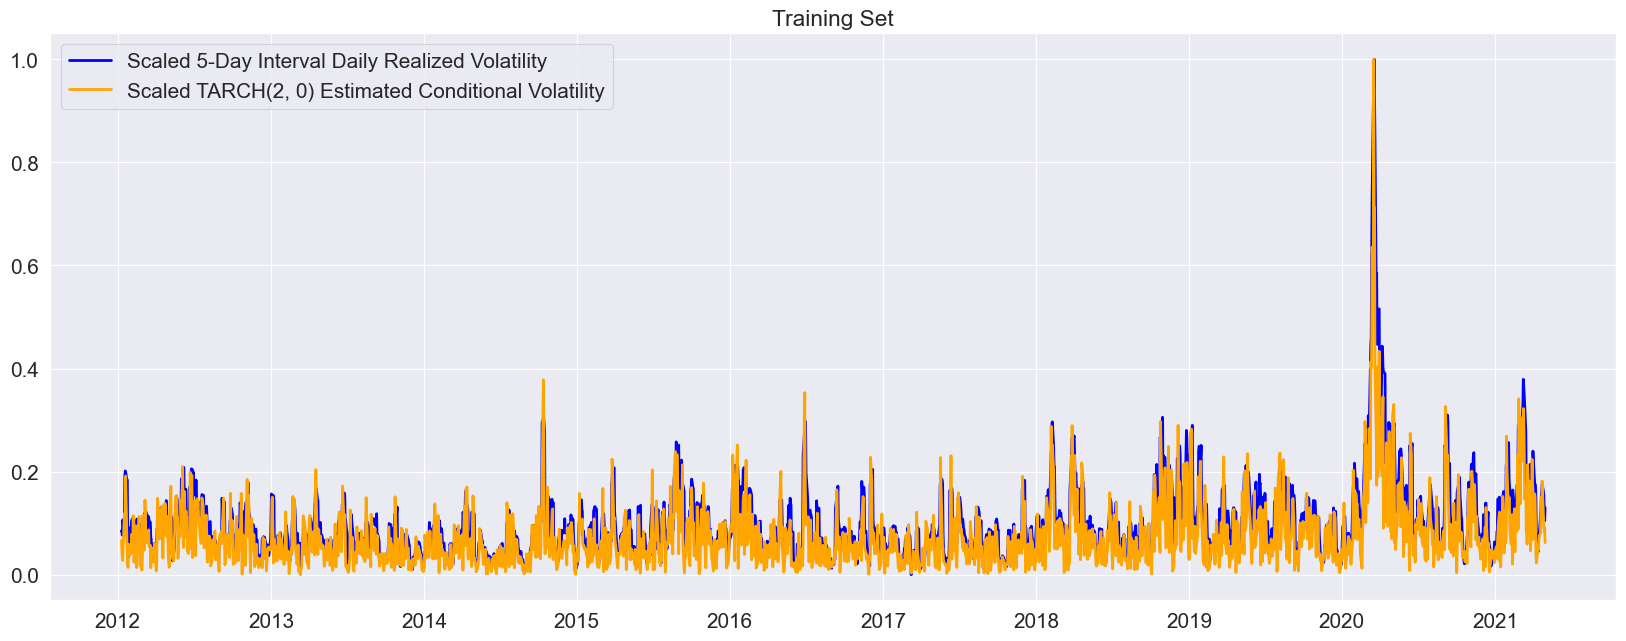

In [113]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [114]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=2, q=2, o=0, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [115]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

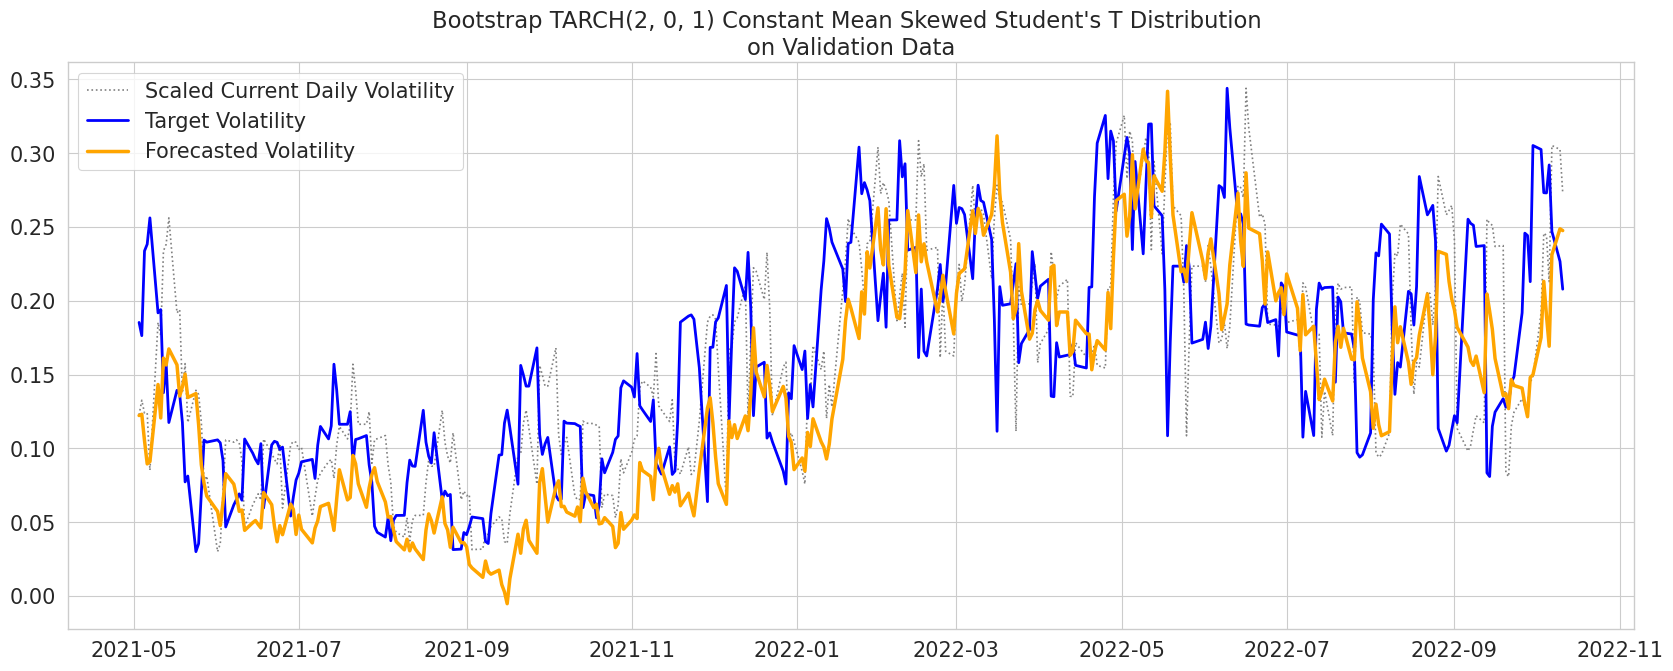

In [116]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.show()

In [117]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.640507   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.641632   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.512318   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548  
4         0.076331      -0.070027  
5         0.076586      -0.077172  
6         0.068109       0.148065

## 4. Neural Networks

In [118]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Normalization, Discretization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [119]:
# CONVERT INPUT & OUTPUT SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [120]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [121]:
def forecast(model, range_idx):
    '''
    Generate predictions for a time period 'range_idx' 
    using fitted 'model' with 'n_past' value preassigned
    '''
    #Add +6 in the calculation to set the value length to 365 as the trading in stock exchange is not a uniform daily series
    start_idx = range_idx[0] - timedelta(n_past - 1 + 6) 
    #start_idx = train_idx[split_time_1 - n_past]

    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.Vol_Current_5d[start_idx:end_idx], 
                                    df.Vol_Future_5d[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds


In [122]:
def scale(scaler, y_series):
    '''
    Transform y_series using fitted scaler
    into another series with the same datetime index
    '''
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [123]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.1 Neural Network Baseline Metrics - Fully Connected Network

In [124]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [125]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

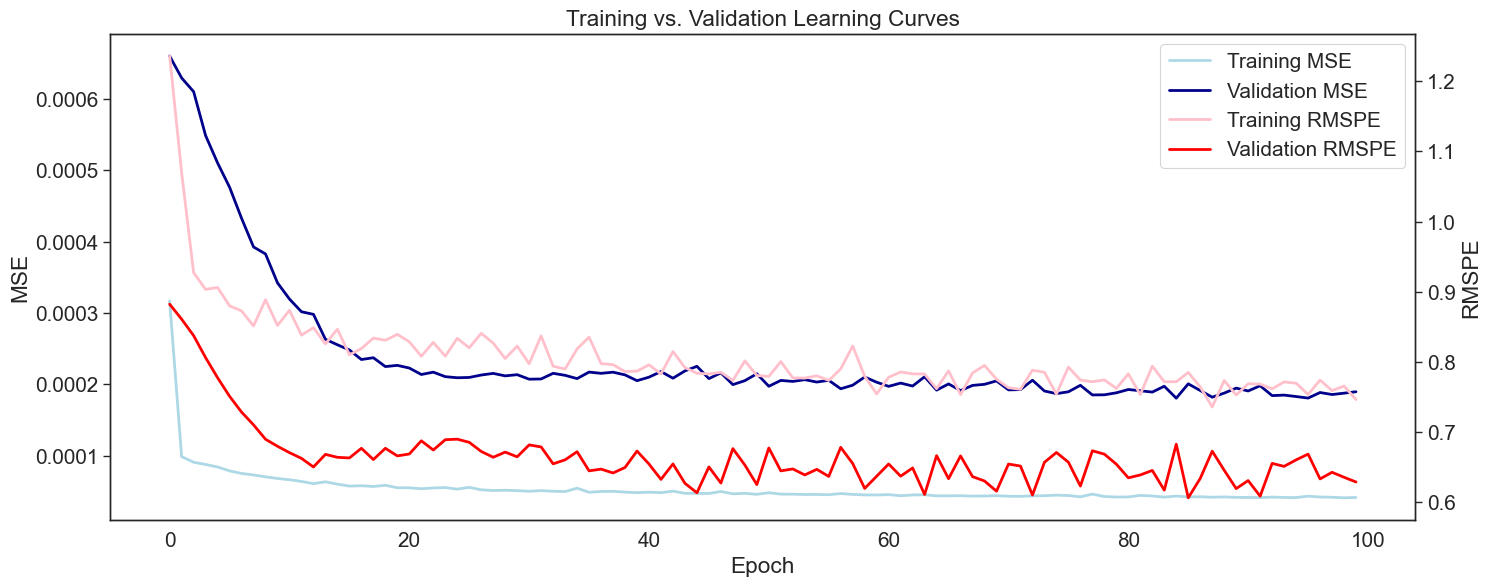

In [126]:
viz_train_val_metrics(snn_1_res)

In [127]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


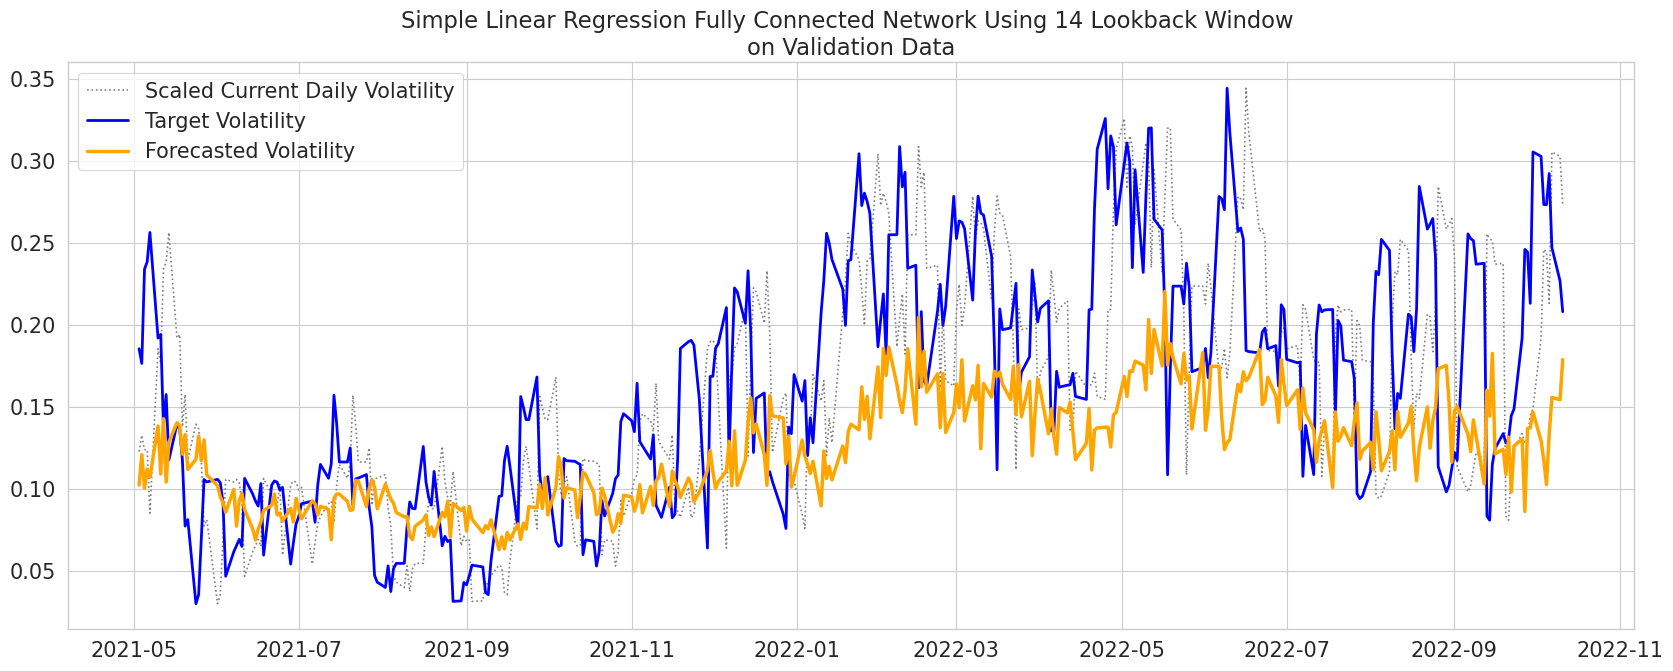

In [128]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")

In [129]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.640507   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.641632   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.512318   
7                 Simple LR Fully Connected NN, n_past=14          0.478130   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548  
4         0.076331      -0.070027  
5         0.076586      -0.077172  
6         0.068109       0.148065  
7         0.072496       0.034801

### 4.2 Univariate Long Short-Term Memory (LSTM)

In [130]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  mode = 'min',
                                  monitor='val_rmspe',
                                  mode = 'min')

print(lstm_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [131]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

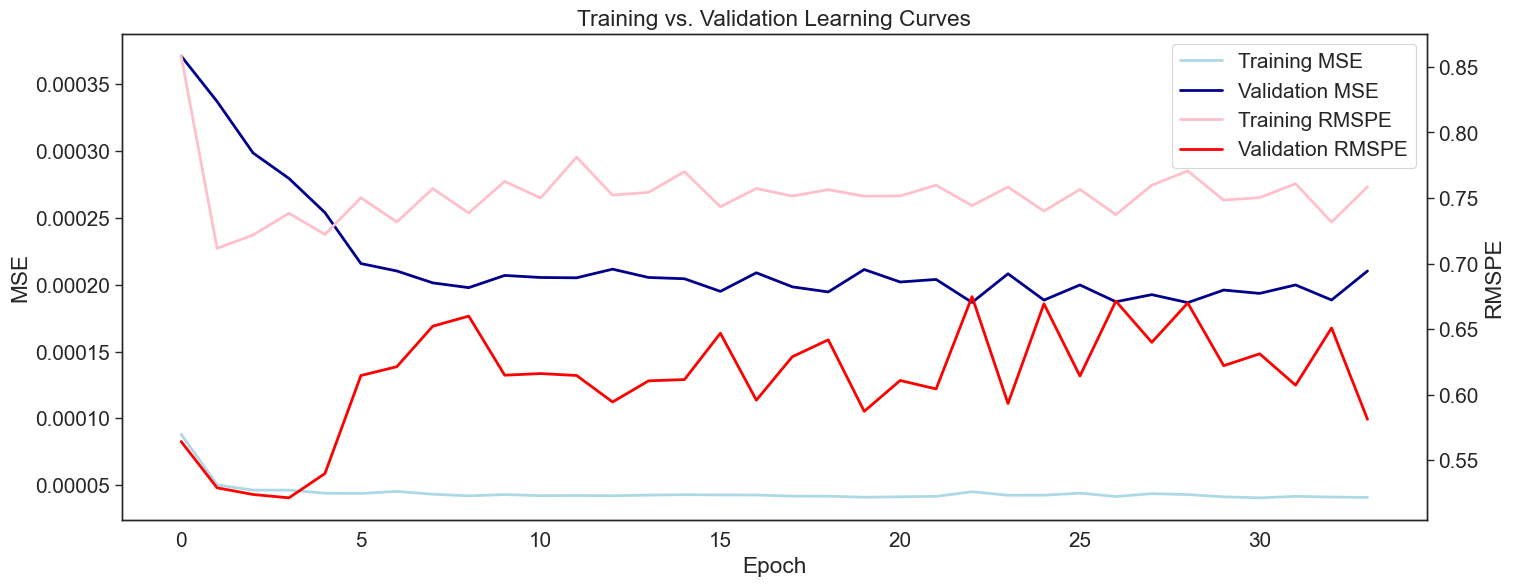

In [132]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

In [133]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


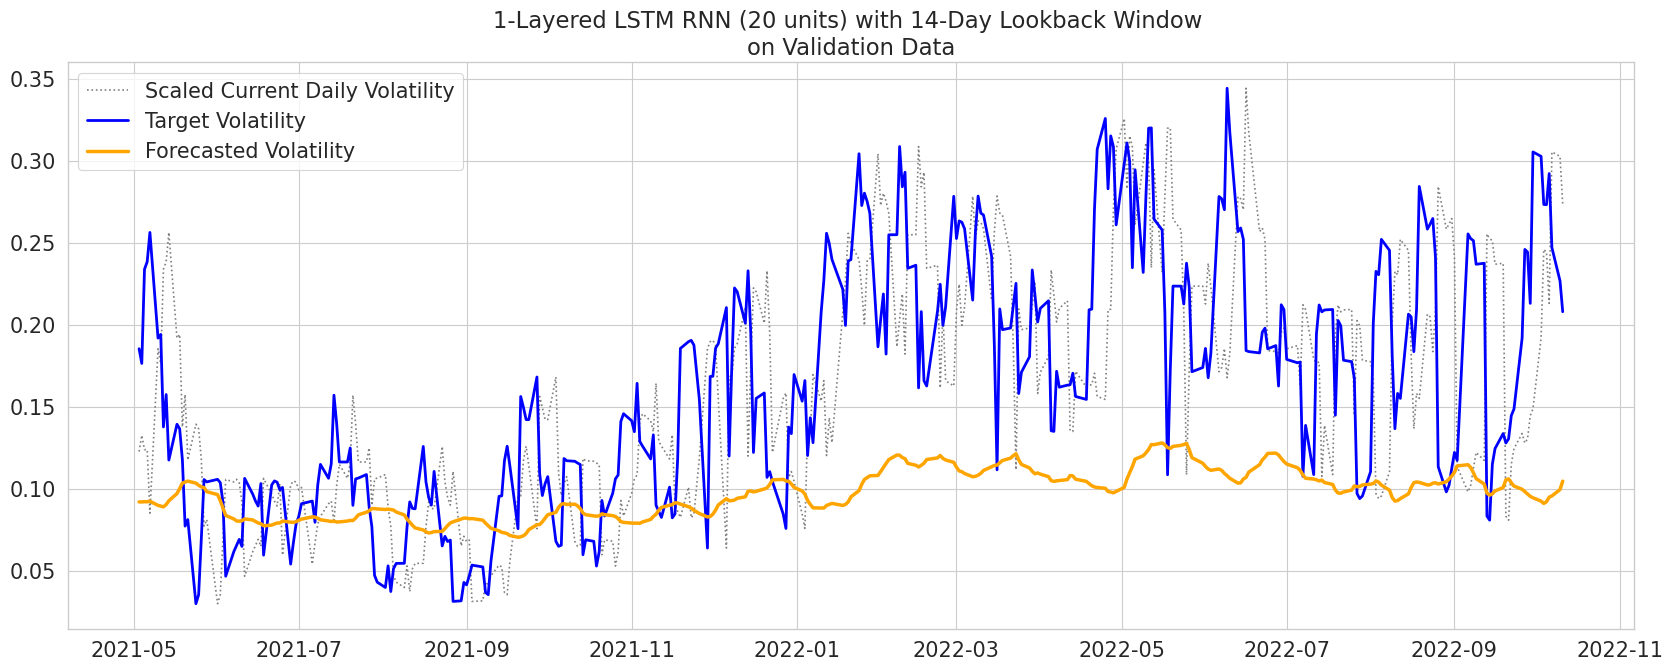

In [134]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

In [135]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.640507   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.641632   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.512318   
7                 Simple LR Fully Connected NN, n_past=14          0.478130   
8                        LSTM 1 layer 20 units, n_past=14          0.494078   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548  
4         0.076331      -0.070027  
5         0.076586      -0.077172  
6         0.068109       0.148065  
7         0.072496       0.034801  
8         0.093671      -0.611386

### 4.3. Univariate Bidirectional LSTM

In [140]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe',
                                  mode ='min')

print(lstm_2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [141]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

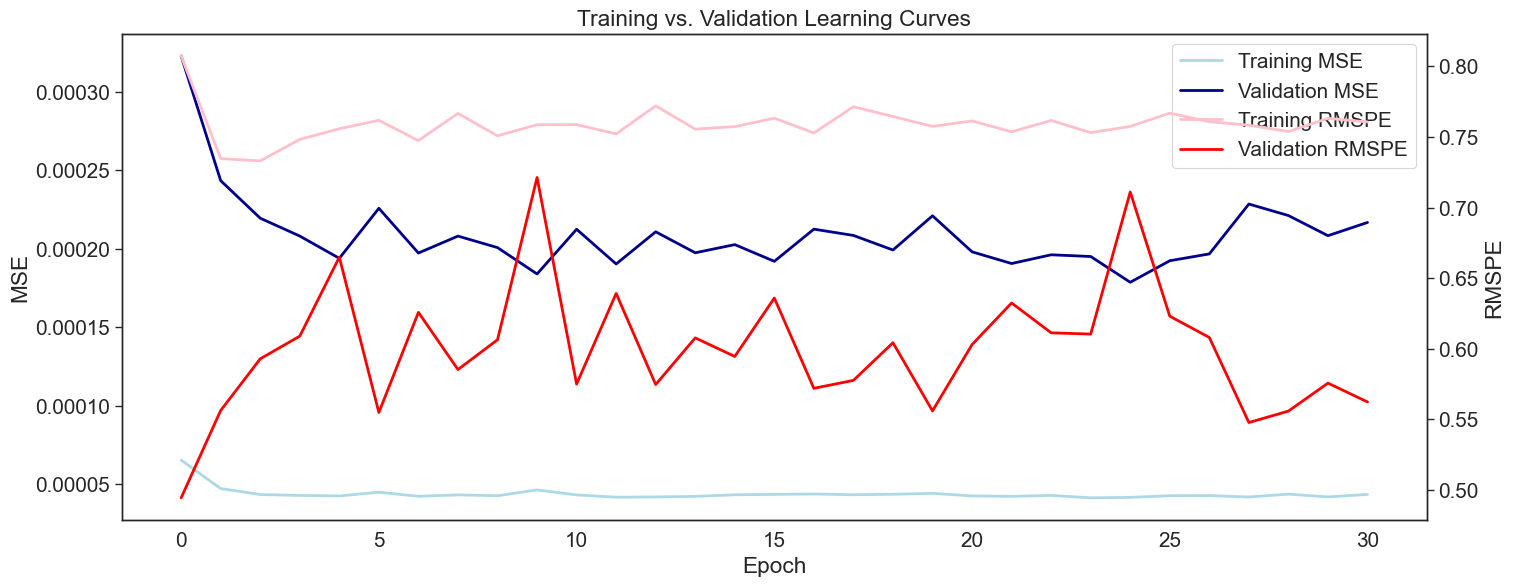

In [142]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [164]:
def forecast2(model, range_idx):
    '''
    Generate predictions for a time period 'range_idx' 
    using fitted 'model' with 'n_past' value preassigned
    '''
    #Add +6 in the calculation to set the value length to 365 as the trading in stock exchange is not a uniform daily series
    start_idx = range_idx[0] - timedelta(n_past - 1 + 13) 

    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.Vol_Current_5d[start_idx:end_idx], 
                                    df.Vol_Future_5d[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [165]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast2(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


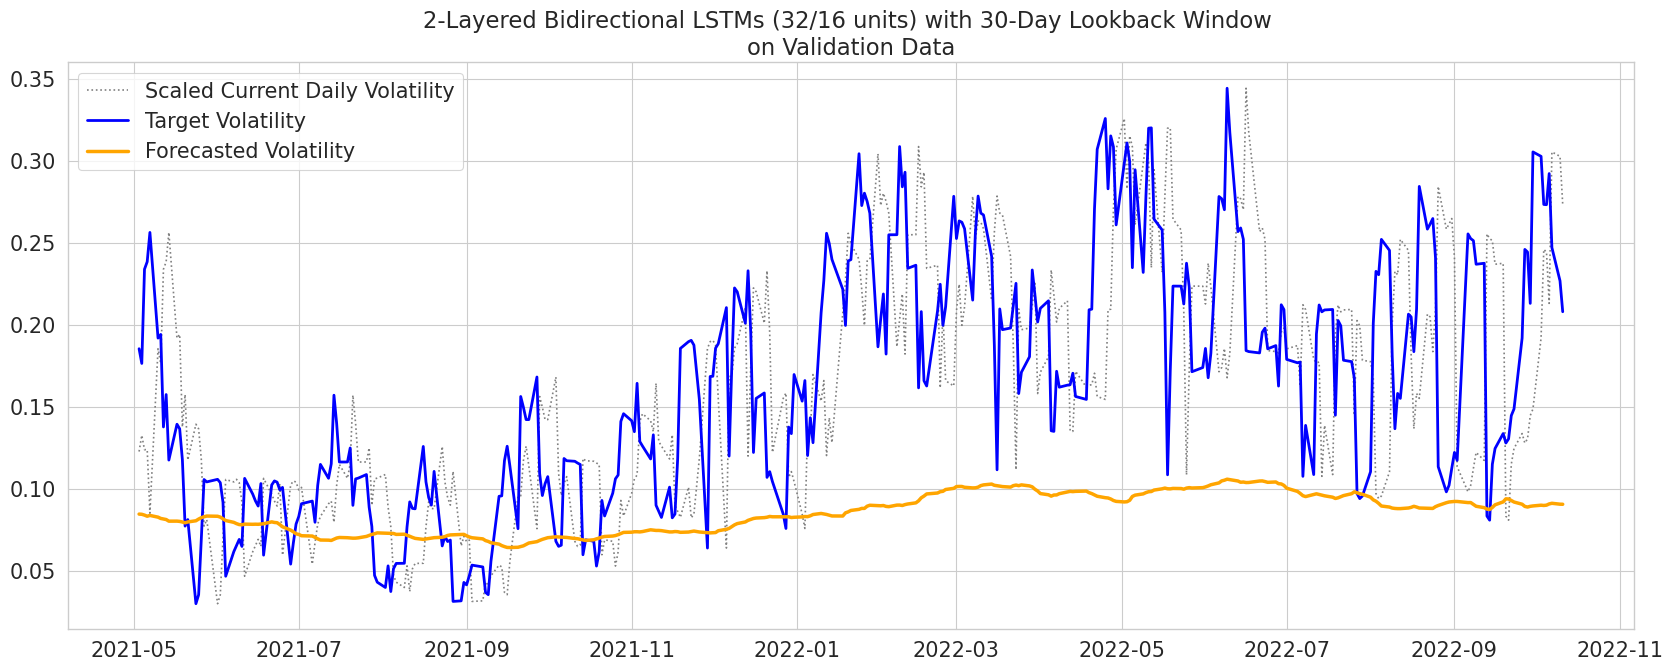

In [158]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")

In [159]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.564868   
1                           Random Walk Naive Forecasting          0.602310   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.534677   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.534655   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.640507   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.641632   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.512318   
7                 Simple LR Fully Connected NN, n_past=14          0.478130   
8                        LSTM 1 layer 20 units, n_past=14          0.494078   
9         2 layers Bidirect LSTM (32/16 units), n_past=30          0.499532   

   Validation RMSE  Validation R2  
0         0.094146      -0.627776  
1         0.070471       0.087971  
2         0.066675       0.183565  
3         0.070255       0.093548  
4         0.076331      -0.070027  
5         0.076586      -0.077172  
6         0.068109       0.148065  
7         0.072496       0.034801  
8         0.093671      -0.611386  
9         0.102662      -0.935579